In [1]:
from helper_funcs_kdd import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import io
from tqdm import tqdm
import time
import jinja2
from scipy.stats import norm
dpi = 200
font_size = 10


In [2]:
# daily highway incidents in california highway from start of 2017 to end of 2020
cal_data = pd.read_excel('../data/CalTransit_Dataset/pems_output.xlsx')
print(cal_data.head(10))
cal_data.rename({"Time": "x", "# Incidents": "y"}, axis=1, inplace=True)
print(len(cal_data))

        Time  # Incidents
0 2017-01-01          862
1 2017-01-02          887
2 2017-01-03         1483
3 2017-01-04         1570
4 2017-01-05         1532
5 2017-01-06         1535
6 2017-01-07         1311
7 2017-01-08         1296
8 2017-01-09         1495
9 2017-01-10         1676
1461


<Figure size 1280x960 with 0 Axes>

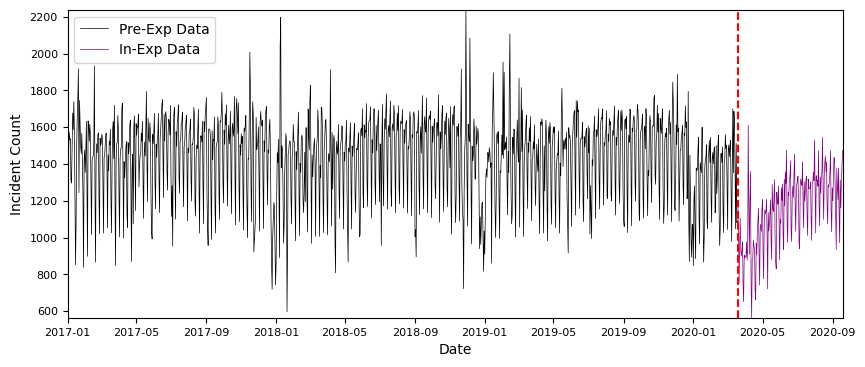

1357 1173 184


In [3]:
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 4))
# Separate train, validation, test data
n = cal_data.shape[0]
# pandemic lockdown started march 19 in california
train_df = cal_data[cal_data['x'] < '2020-03-19'].reset_index(drop=True)
test_df = cal_data[(cal_data['x'] >= '2020-03-19') & (cal_data['x'] < '2020-09-19')].reset_index(drop=True)
# plot
x_range = [min(cal_data['x']), max(cal_data['x'][cal_data['x'] < '2020-09-19'])]
y_range = [min(cal_data['y']), max(cal_data['y'])]
plt.plot(train_df['x'], train_df['y'], color='black',linewidth=0.5,label='Pre-Exp Data')
plt.plot(test_df['x'], test_df['y'], color='purple',linewidth=0.5,label='In-Exp Data')
plt.axvline(x=cal_data['x'][cal_data['x'] == '2020-03-19'], color='red', linestyle='--')
ax = plt.gca()
# Set font size for the x and y axis ticks
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("Date", fontsize=font_size)
ax.set_ylabel("Incident Count", fontsize=font_size)
ax.legend(fontsize = font_size)
plt.savefig('kdd_plots/california_data.png', dpi=dpi)
plt.show()
print(len(train_df) + len(test_df),len(train_df), len(test_df))


<Figure size 1280x960 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

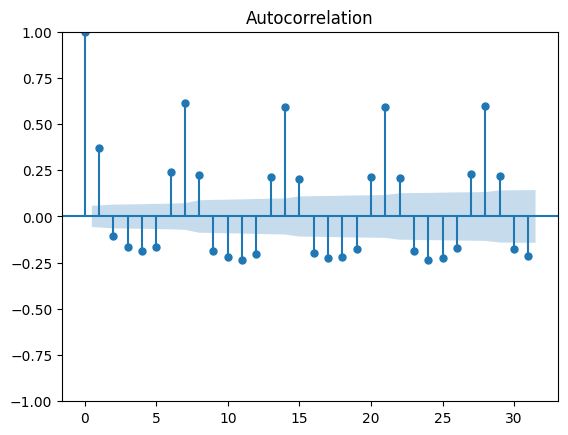

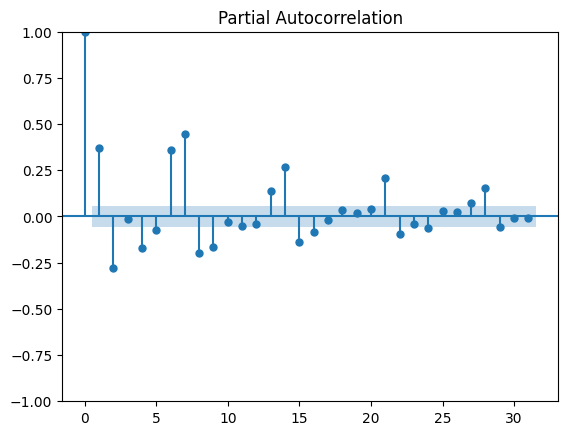

In [4]:
# plot autocorrelation and partial autocorrelation side by side
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(train_df['y'])
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(train_df['y'])
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1280x960 with 0 Axes>

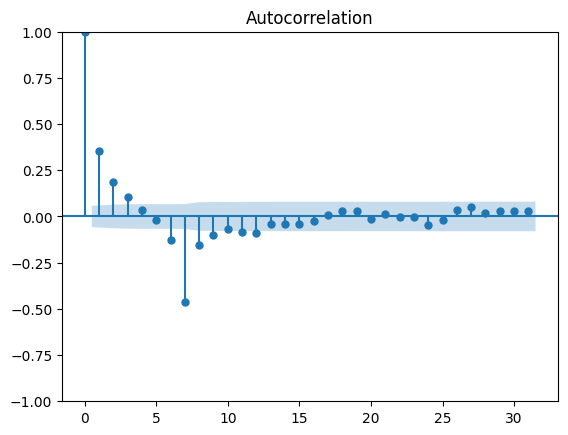

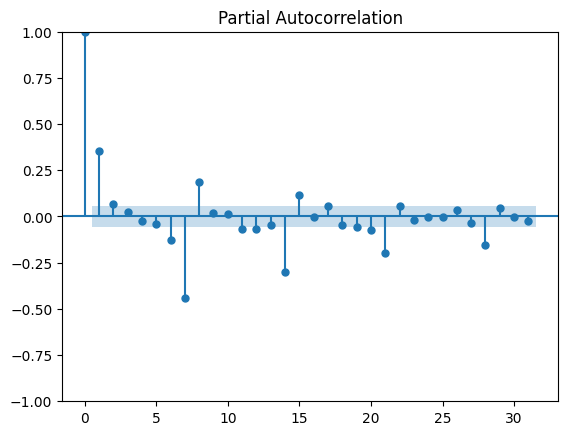

In [5]:
# seasonally differenced data, plot acf and pacf again
diff_y  = train_df['y'].diff(7).dropna()
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_acf(diff_y)
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(diff_y)
plt.title('Partial Autocorrelation')
plt.show()

In [4]:
# Choose parameters to try fitting the model with
p = [0,1]
q = [0,1]
d = [0,1]
P = [0,1]
Q = [0,1]
D = [0,1] # dont need to test 0,1, just remove 1 if testing as run takes too long
S = [7]
#D = [0]
param1 = list(itertools.product(p,d,q))
param2 = list(itertools.product(P,D,Q,S))
best_param1 = param1[0]
best_param2 = param2[0]
for i in range(len(param1)):
    for j in range(len(param2)):
        #print(i,j)
        model = sm.tsa.statespace.SARIMAX(train_df['y'], order = param1[i], seasonal_order = param2[j])
        result = model.fit(disp=False)
        tb = result.summary().tables[0].as_html()
        readable_tb = pd.read_html(io.StringIO(tb),header=None,index_col=None)[0] 
        cur_aic = readable_tb[3][2]
        if i == 0 and j == 0:
            best_aic = cur_aic
        elif cur_aic < best_aic:
            best_aic = cur_aic
            best_param1 = param1[i]
            best_param2 = param2[j]
best_aic, best_param1, best_param2
opt_model = sm.tsa.statespace.SARIMAX(train_df['y'], order = best_param1, seasonal_order = best_param2)
opt_res = opt_model.fit(disp=False)


/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/Mast

<Figure size 2000x1200 with 0 Axes>

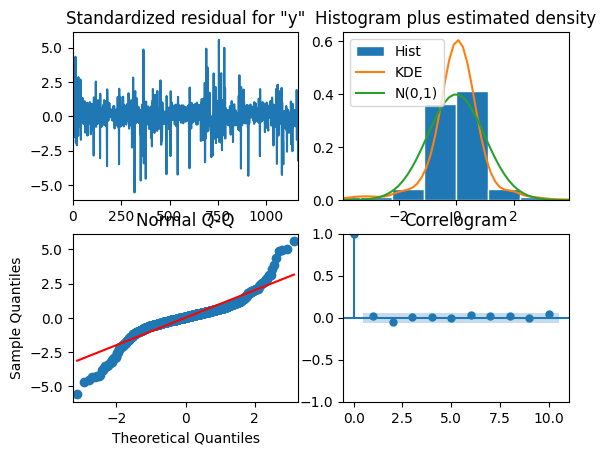

In [5]:
# fit the best model and check residuals
plt.figure(figsize=(10, 6),dpi=dpi)
opt_res = opt_model.fit(disp=False)
opt_res.plot_diagnostics()
plt.show()

In [6]:
result = opt_model.fit(disp=False)
tb = result.summary().tables[0].as_html()
readable_tb = pd.read_html(io.StringIO(tb),header=None,index_col=None)[0] 
print(readable_tb)

                  0                              1                  2  \
0    Dep. Variable:                              y  No. Observations:   
1            Model:  SARIMAX(1, 0, 1)x(0, 1, 1, 7)     Log Likelihood   
2             Date:               Fri, 17 Jan 2025                AIC   
3             Time:                       15:06:04                BIC   
4           Sample:                              0               HQIC   
5               NaN                         - 1173                NaN   
6  Covariance Type:                            opg                NaN   

           3  
0   1173.000  
1  -7401.979  
2  14811.958  
3  14832.204  
4  14819.595  
5        NaN  
6        NaN  


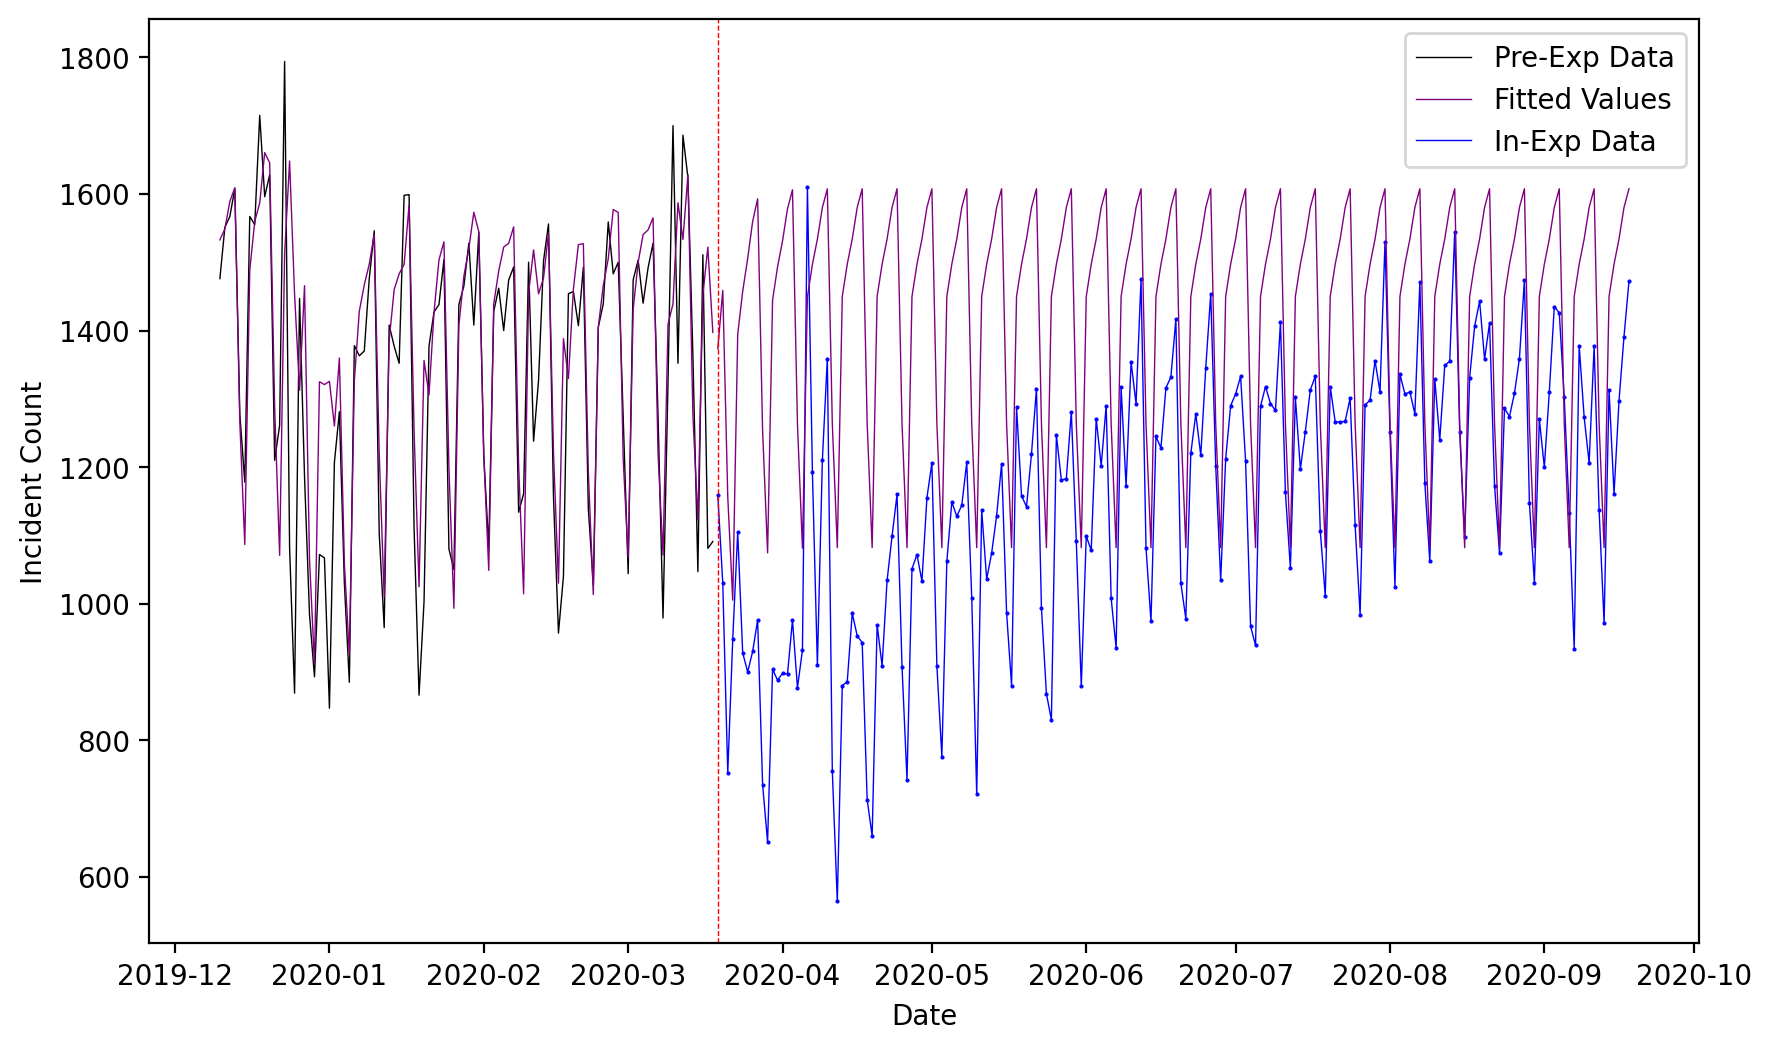

In [7]:
# predict values for test data and plot against actual test data
plt.figure(figsize=(10,6), dpi = dpi)
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)).predicted_mean.reset_index(drop=True) # watch index here as it is reset when train test split
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'], test_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(test_df['x'], test_df['y'], color='blue', linewidth = 0.5, label='In-Exp Data')
plt.plot(test_df['x'], pred, color='purple', ls = '-', linewidth=0.5)
# plot a vertical line to show the start of the test data
plt.axvline(x=test_df['x'].iloc[0], color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend()
plt.show()


Const:  (np.float64(10.299999999999955), np.float64(66.32073185425664))
Reg:  (np.float64(37.90248997859794), np.float64(51.1338514827635))
Pred:  (np.float64(-2.0061099535870426), np.float64(50.818497700163576))
Sec:  (np.float64(17.581730933777862), np.float64(42.663271289032735))


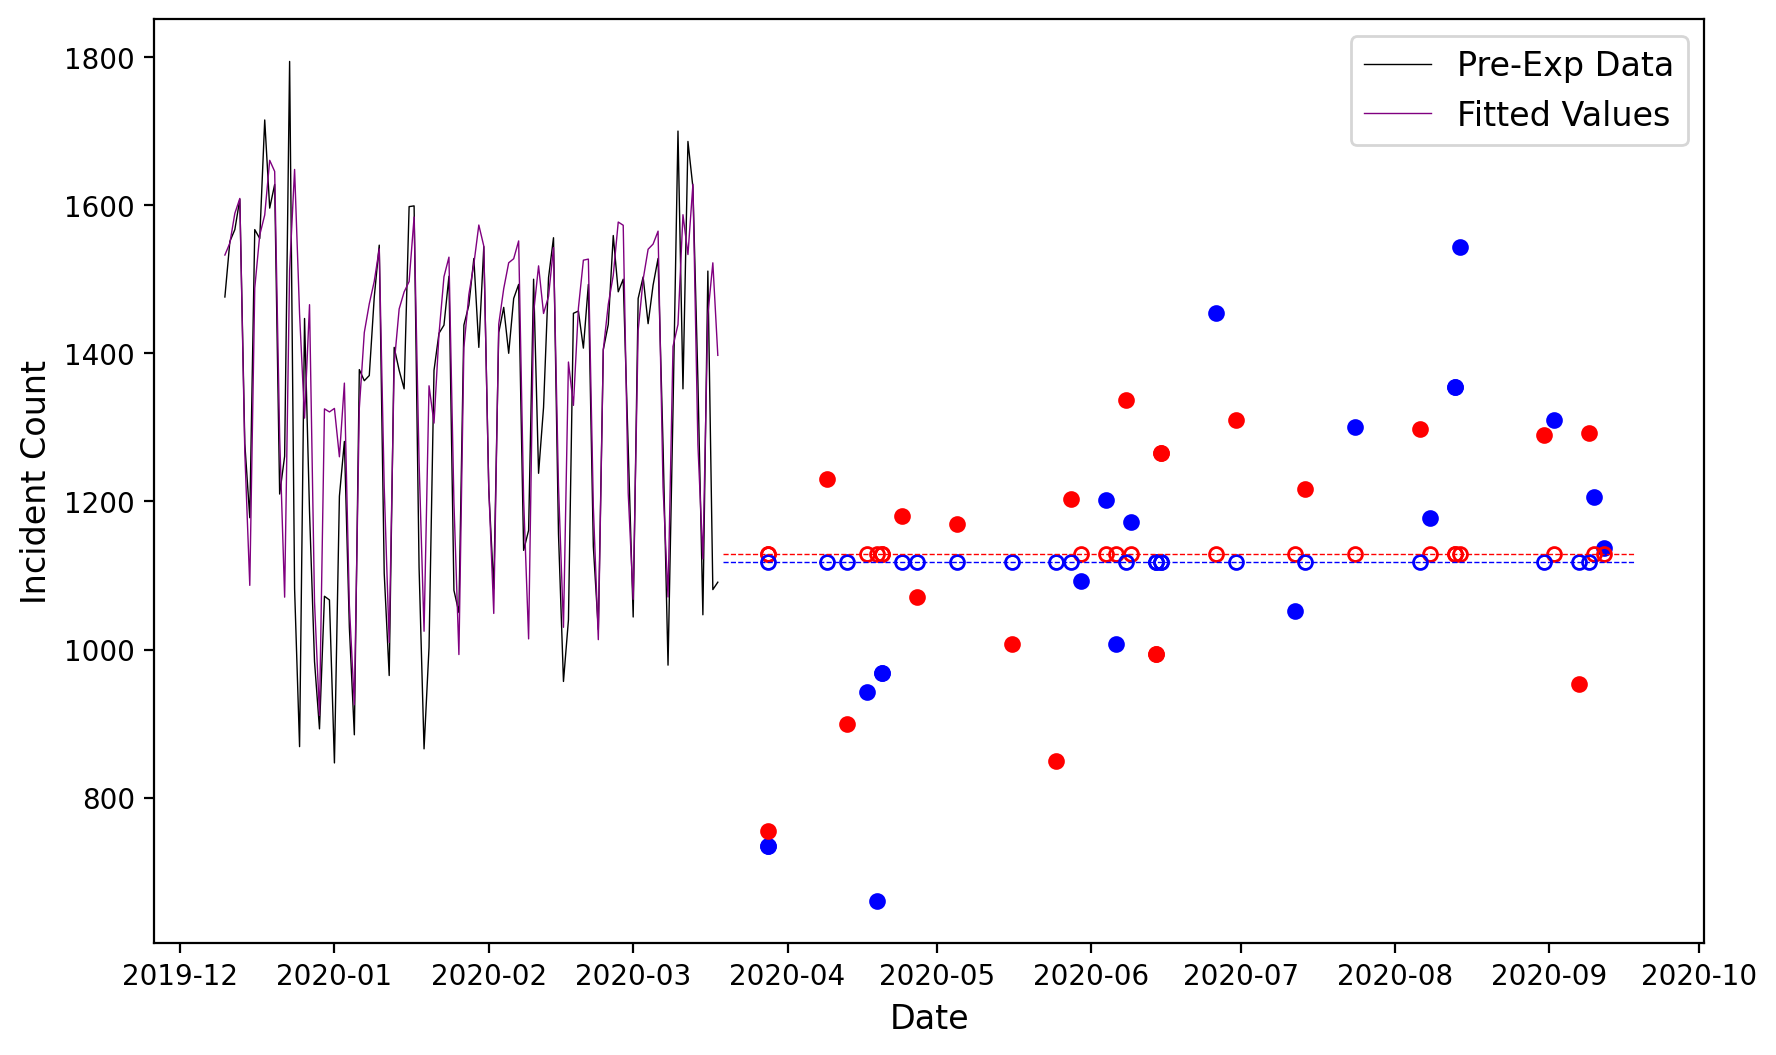

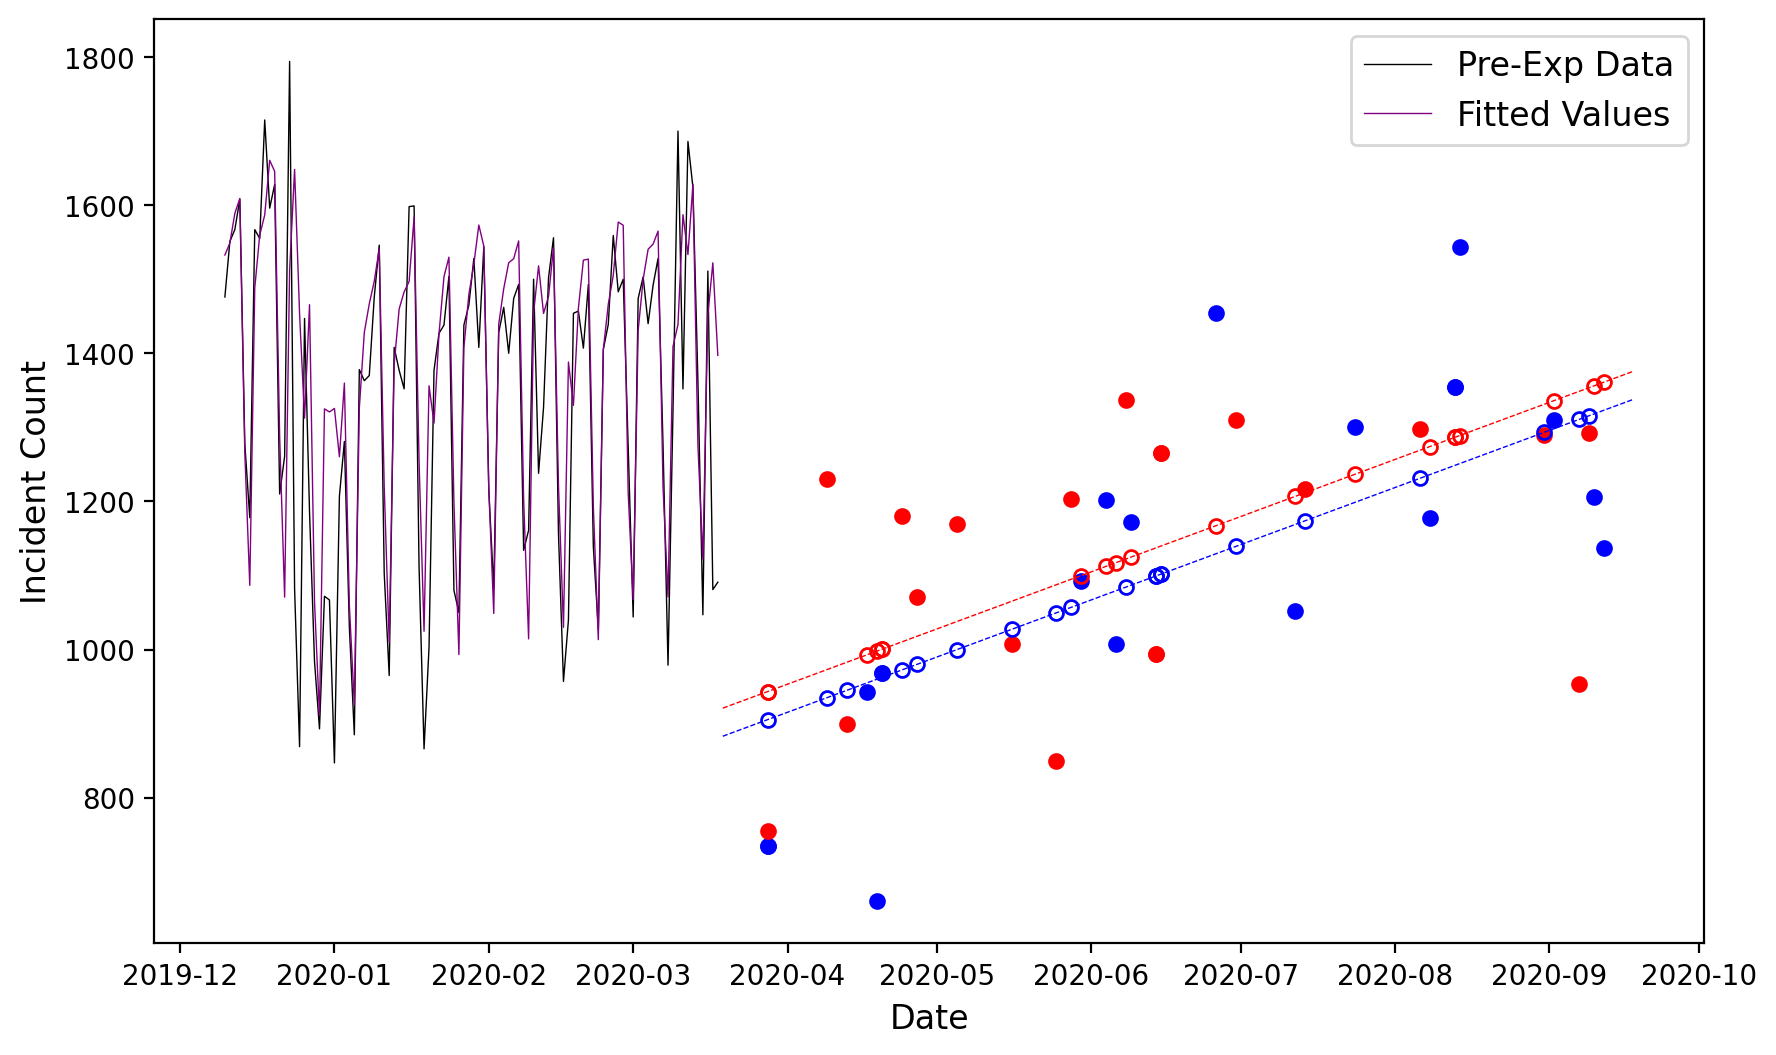

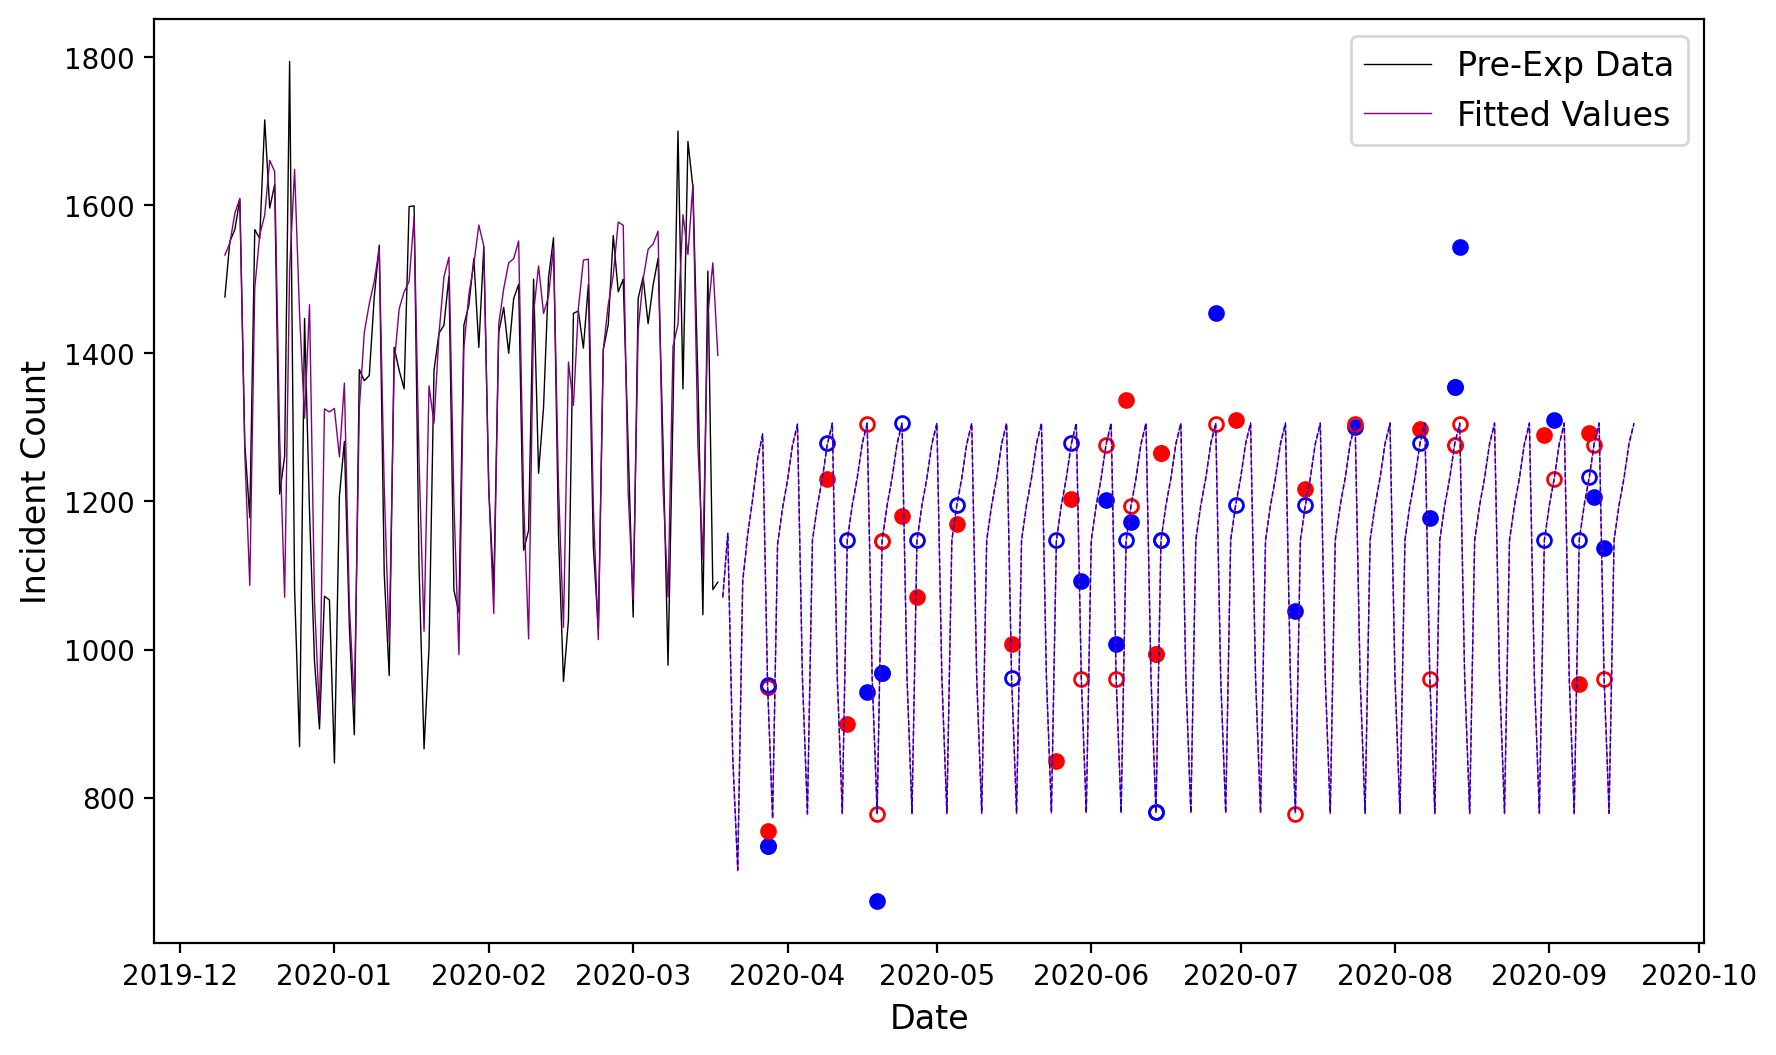

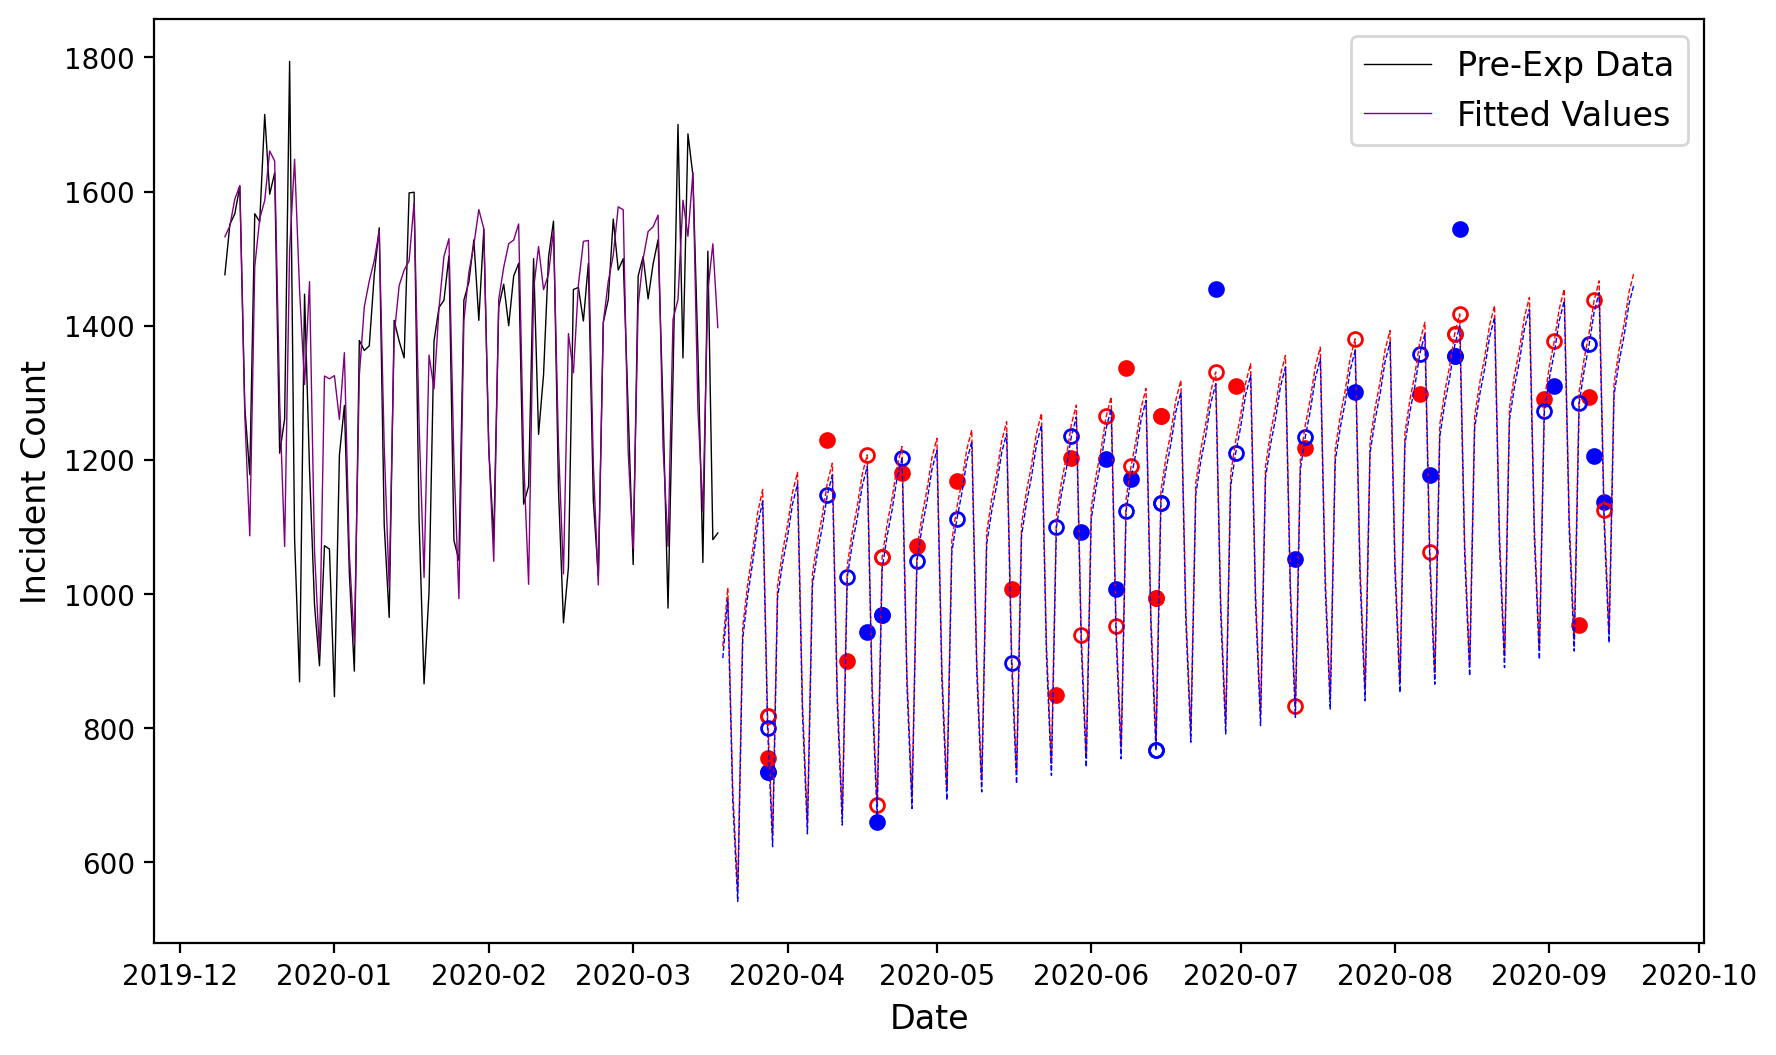

In [8]:
# simulate experiment by randomly assigning treatment to some data points
np.random.seed(0)
# treatment effect - say increase of 50 incidents
test_len = len(test_df)
# convert date in test data to integer, with minimum date being 0 - this is for regression and secondary adjustment later
clean_test_df = traffic_preprocess(test_df.copy())
n = 20
te = 20
# randomly assign treatment
control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(clean_test_df, te, n) # indices of dfs not reset - doesn't matter i think?
#print(pred, pred[control_idx], pred[treatment_idx])

# generate counterfactuals with constant model
const_c = np.full(len(control_df),treatment_df['y'].mean())
const_t = np.full(len(treatment_df), control_df['y'].mean())
# counterfactuals over entire test data
const_c_all = np.full(len(clean_test_df), treatment_df['y'].mean())
const_t_all = np.full(len(clean_test_df), control_df['y'].mean())
print("Const: ",calculate_ate(control_df, treatment_df))

# generate counterfactuals with regression model
y_1 = to_matrix(treatment_df['y'])
yc_1 = y_1 - y_1.mean()
y_0 = to_matrix(control_df['y'])
yc_0 = y_0 - y_0.mean()
x_0 = to_matrix(control_df.drop(columns = ['y']))
xc_0 = x_0 - np.mean(x_0, axis=0)
x_1 = to_matrix(treatment_df.drop(columns = ['y']))
xc_1 = x_1 - np.mean(x_1, axis=0)
#print(y_1, y_0, x_1, x_0)
# calculate the beta coefficients
treatxvar = xc_1.T @ xc_1
controlxvar = xc_0.T @ xc_0
treatxcov = xc_1.T @ yc_1
controlxcov = xc_0.T @ yc_0
beta = np.linalg.inv(treatxvar + controlxvar) @ (treatxcov + controlxcov)
# calculate the average treatment effect and standard error
xbar_1 = to_matrix(np.mean(x_1, axis=0)) # np.mean reduces the dimension so we need to turn it back to matrix
xbar_0 = to_matrix(np.mean(x_0, axis=0))
alpha_1 = np.mean(y_1) - xbar_1.T @ beta
alpha_0 = np.mean(y_0) - xbar_0.T @ beta
reg_c = alpha_1 + x_0 @ beta
reg_t = alpha_0 + x_1 @ beta
# counterfactuals over entire test data
reg_c_all = alpha_1 + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta
reg_t_all = alpha_0 + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta
print("Reg: ", calculate_ate_reg(control_df, treatment_df))

# generate counterfactuals with prediction model
y_1 = treatment_df['y']
y_0 = control_df['y']
# get prediction for the instance of control and treatment data
control_pred = pred[control_idx].reset_index(drop=True)
treatment_pred = pred[treatment_idx].reset_index(drop=True)
alpha_1 = np.mean(y_1 - treatment_pred)
alpha_0 = np.mean(y_0 - control_pred)
pred_c = control_pred + alpha_1
pred_t = treatment_pred + alpha_0
# counterfactuals over entire test data
pred_c_all = pred + alpha_1
pred_t_all = pred + alpha_0
print("Pred: ", calculate_ate_pred(control_df, treatment_df, pred, control_idx, treatment_idx))

# generate counterfactuals with secondary adjustment model
y_1 = to_matrix(treatment_df['y'] - treatment_pred)
yc_1 = y_1 - y_1.mean()
y_0 = to_matrix(control_df['y'] - control_pred)
yc_0 = y_0 - y_0.mean()
x_0 = to_matrix(control_df.drop(columns = ['y']))
xc_0 = x_0 - np.mean(x_0, axis=0)
x_1 = to_matrix(treatment_df.drop(columns = ['y']))
xc_1 = x_1 - np.mean(x_1, axis=0)
#print(x_1, x_0, y_1, y_0)
# calculate the beta coefficients
treatxvar = xc_1.T @ xc_1
controlxvar = xc_0.T @ xc_0
treatxcov = xc_1.T @ yc_1
controlxcov = xc_0.T @ yc_0
beta = np.linalg.inv(treatxvar + controlxvar) @ (treatxcov + controlxcov)
# calculate the average treatment effect and standard error
xbar_1 = to_matrix(np.mean(x_1, axis=0)) # np.mean reduces the dimension so we need to turn it back to matrix
xbar_0 = to_matrix(np.mean(x_0, axis=0))
alpha_1 = np.mean(y_1) - xbar_1.T @ beta
alpha_0 = np.mean(y_0) - xbar_0.T @ beta
#print(control_pred.shape, (x_0 @ beta).shape)
second_c = to_matrix(control_pred) + x_0 @ beta + alpha_1
second_t = to_matrix(treatment_pred) +  x_1 @ beta + alpha_0
# counterfactuals over entire test data
second_c_all = to_matrix(pred) + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta + alpha_1
second_t_all = to_matrix(pred) + to_matrix(clean_test_df.drop(columns = ['y'])) @ beta + alpha_0
print("Sec: ",calculate_ate_sec(control_df, treatment_df, pred, control_idx, treatment_idx))

# Set font size for xlabel, ylabel, and legend in the plots
font_size = 12

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize=5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize=5)
plt.plot(test_df['x'][control_idx], const_c, 'o', color='red', markersize=5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], const_t, 'o', color='blue', markersize=5, fillstyle='none')
plt.plot(test_df['x'], const_c_all, color='red', linewidth=0.5, ls='--')
plt.plot(test_df['x'], const_t_all, color='blue', linewidth=0.5, ls='--')
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Incident Count', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig('kdd_plots/HI_const.png', dpi=dpi)
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize=5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize=5)
plt.plot(test_df['x'][control_idx], reg_c, 'o', color='red', markersize=5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], reg_t, 'o', color='blue', markersize=5, fillstyle='none')
plt.plot(test_df['x'], reg_c_all, color='red', linewidth=0.5, ls='--')
plt.plot(test_df['x'], reg_t_all, color='blue', linewidth=0.5, ls='--')
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Incident Count', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig('kdd_plots/HI_reg.png', dpi=dpi)
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize=5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize=5)
plt.plot(test_df['x'][control_idx], pred_c, 'o', color='red', markersize=5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], pred_t, 'o', color='blue', markersize=5, fillstyle='none')
plt.plot(test_df['x'], pred_c_all, color='red', linewidth=0.5, ls='--')
plt.plot(test_df['x'], pred_t_all, color='blue', linewidth=0.5, ls='--')
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Incident Count', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig('kdd_plots/HI_pred.png', dpi=dpi)
plt.show()

plt.figure(figsize=(10, 6), dpi=dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'][control_idx], control_df['y'], 'o', color='blue', markersize=5)
plt.plot(test_df['x'][treatment_idx], treatment_df['y'], 'o', color='red', markersize=5)
plt.plot(test_df['x'][control_idx], second_c, 'o', color='red', markersize=5, fillstyle='none')
plt.plot(test_df['x'][treatment_idx], second_t, 'o', color='blue', markersize=5, fillstyle='none')
plt.plot(test_df['x'], second_c_all, color='red', linewidth=0.5, ls='--')
plt.plot(test_df['x'], second_t_all, color='blue', linewidth=0.5, ls='--')
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Incident Count', fontsize=font_size)
plt.legend(fontsize=font_size, loc = 'upper right')
plt.savefig('kdd_plots/HI_sec.png', dpi=dpi)
plt.show()


In [9]:
# run simulation

# set seed for reproducibility
np.random.seed(0)

# simulation parameters
te_lst = [0, 10, 20, 50]
n_lst = [100, 200, 500, 1000]
r = 10000
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)).predicted_mean.reset_index(drop=True)
test_df_clean = traffic_preprocess(test_df.copy()) # get rid of the date, convert to integer
# rejection threshold for 5% alpha
threshold = norm.ppf(0.975)

# save results here
# pre-determine size for efficiency
total = len(te_lst)*len(n_lst)*r
rows = np.zeros((total, 12))

# set up tqdm in the outer loop 
with tqdm(total=total, desc="Overall Progress") as pbar:
    idx = 0
    for te in te_lst: 
        for n in n_lst:
            for i in range(r):
                # randomly generate an instance of experiment data
                control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(test_df_clean, te, n)

                # constant model
                ate, se = calculate_ate(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row = [ate, se, rej]

                # regression model
                ate, se = calculate_ate_reg(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # prediction model
                #print(control_df, control_idx)
                ate, se = calculate_ate_pred(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # secondary adjustment model
                ate, se = calculate_ate_sec(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])
                
                rows[idx, :] = row
                idx += 1
                pbar.update(1)

# convert to dataframe
colnames = ['Constant ATE', 'Constant SE', 'Constant Rej', 
            'Regression ATE', 'Regression SE', 'Regression Rej',
            'Prediction ATE', 'Prediction SE', 'Prediction Rej',
            'Secondary ATE', 'Secondary SE', 'Secondary Rej']
results = pd.DataFrame(rows, columns=colnames)

            


Overall Progress: 100%|██████████| 160000/160000 [05:08<00:00, 517.91it/s]


In [10]:
# add columns for the simulation parameters
results['te'] = np.repeat(te_lst, len(n_lst)*r)
results['n'] = np.tile(np.repeat(n_lst, r), len(te_lst))
results.iloc[-100:]

,Constant ATE,Constant SE,Constant Rej,Regression ATE,Regression SE,Regression Rej,Prediction ATE,Prediction SE,Prediction Rej,Secondary ATE,Secondary SE,Secondary Rej,te,n
159900,52.611,8.915740,1.0,52.084239,7.203440,1.0,40.495651,7.533996,1.0,40.000021,5.690611,1.0,50,1000
159901,39.238,8.991959,1.0,40.709030,7.203992,1.0,44.990930,7.448836,1.0,46.282406,5.763734,1.0,50,1000
159902,38.961,8.749968,1.0,47.091321,7.104423,1.0,41.339254,7.456993,1.0,49.325716,5.521627,1.0,50,1000
159903,40.161,8.971616,1.0,45.935892,7.337933,1.0,44.287743,7.563596,1.0,49.649997,5.855962,1.0,50,1000
159904,25.860,9.018813,1.0,38.294259,7.361227,1.0,32.050775,7.640567,1.0,43.980348,5.783139,1.0,50,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,54.529,8.916945,1.0,55.377388,7.201988,1.0,52.675388,7.386224,1.0,53.463685,5.544808,1.0,50,1000
159996,40.138,8.991468,1.0,36.707997,7.157284,1.0,55.349267,7.391683,1.0,52.185980,5.431320,1.0,50,1000
159997,64.274,8.982035,1.0,62.857510,7.320876,1.0,51.113849,7.407942,1.0,49.845021,5.762186,1.0,50,1000
159998,49.065,8.801427,1.0,46.425598,7.038525,1.0,60.612031,7.453139,1.0,58.097093,5.500193,1.0,50,1000


/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


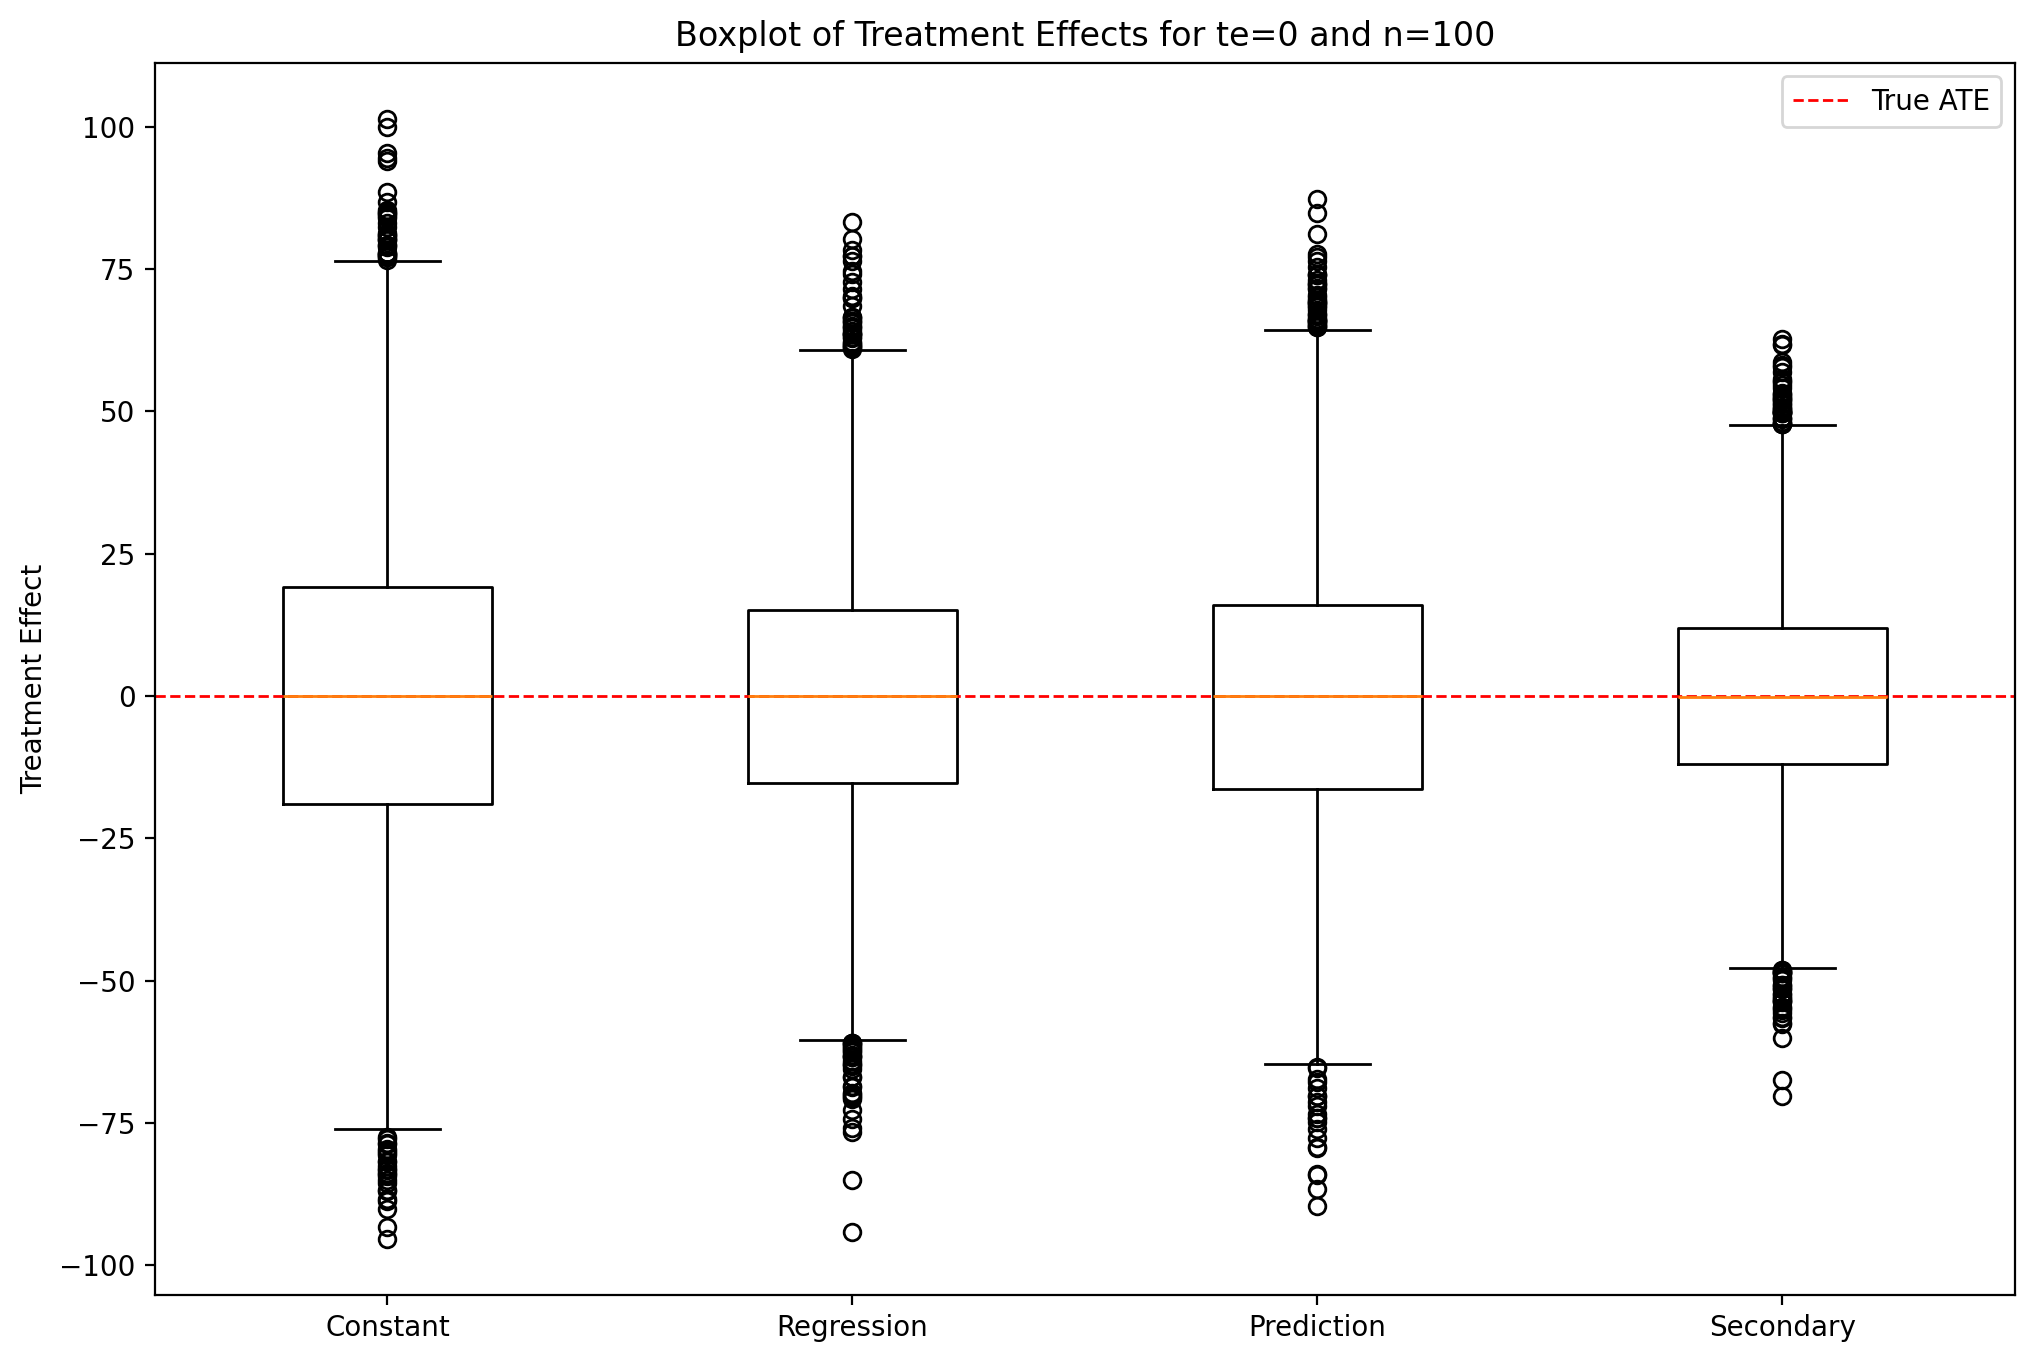

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


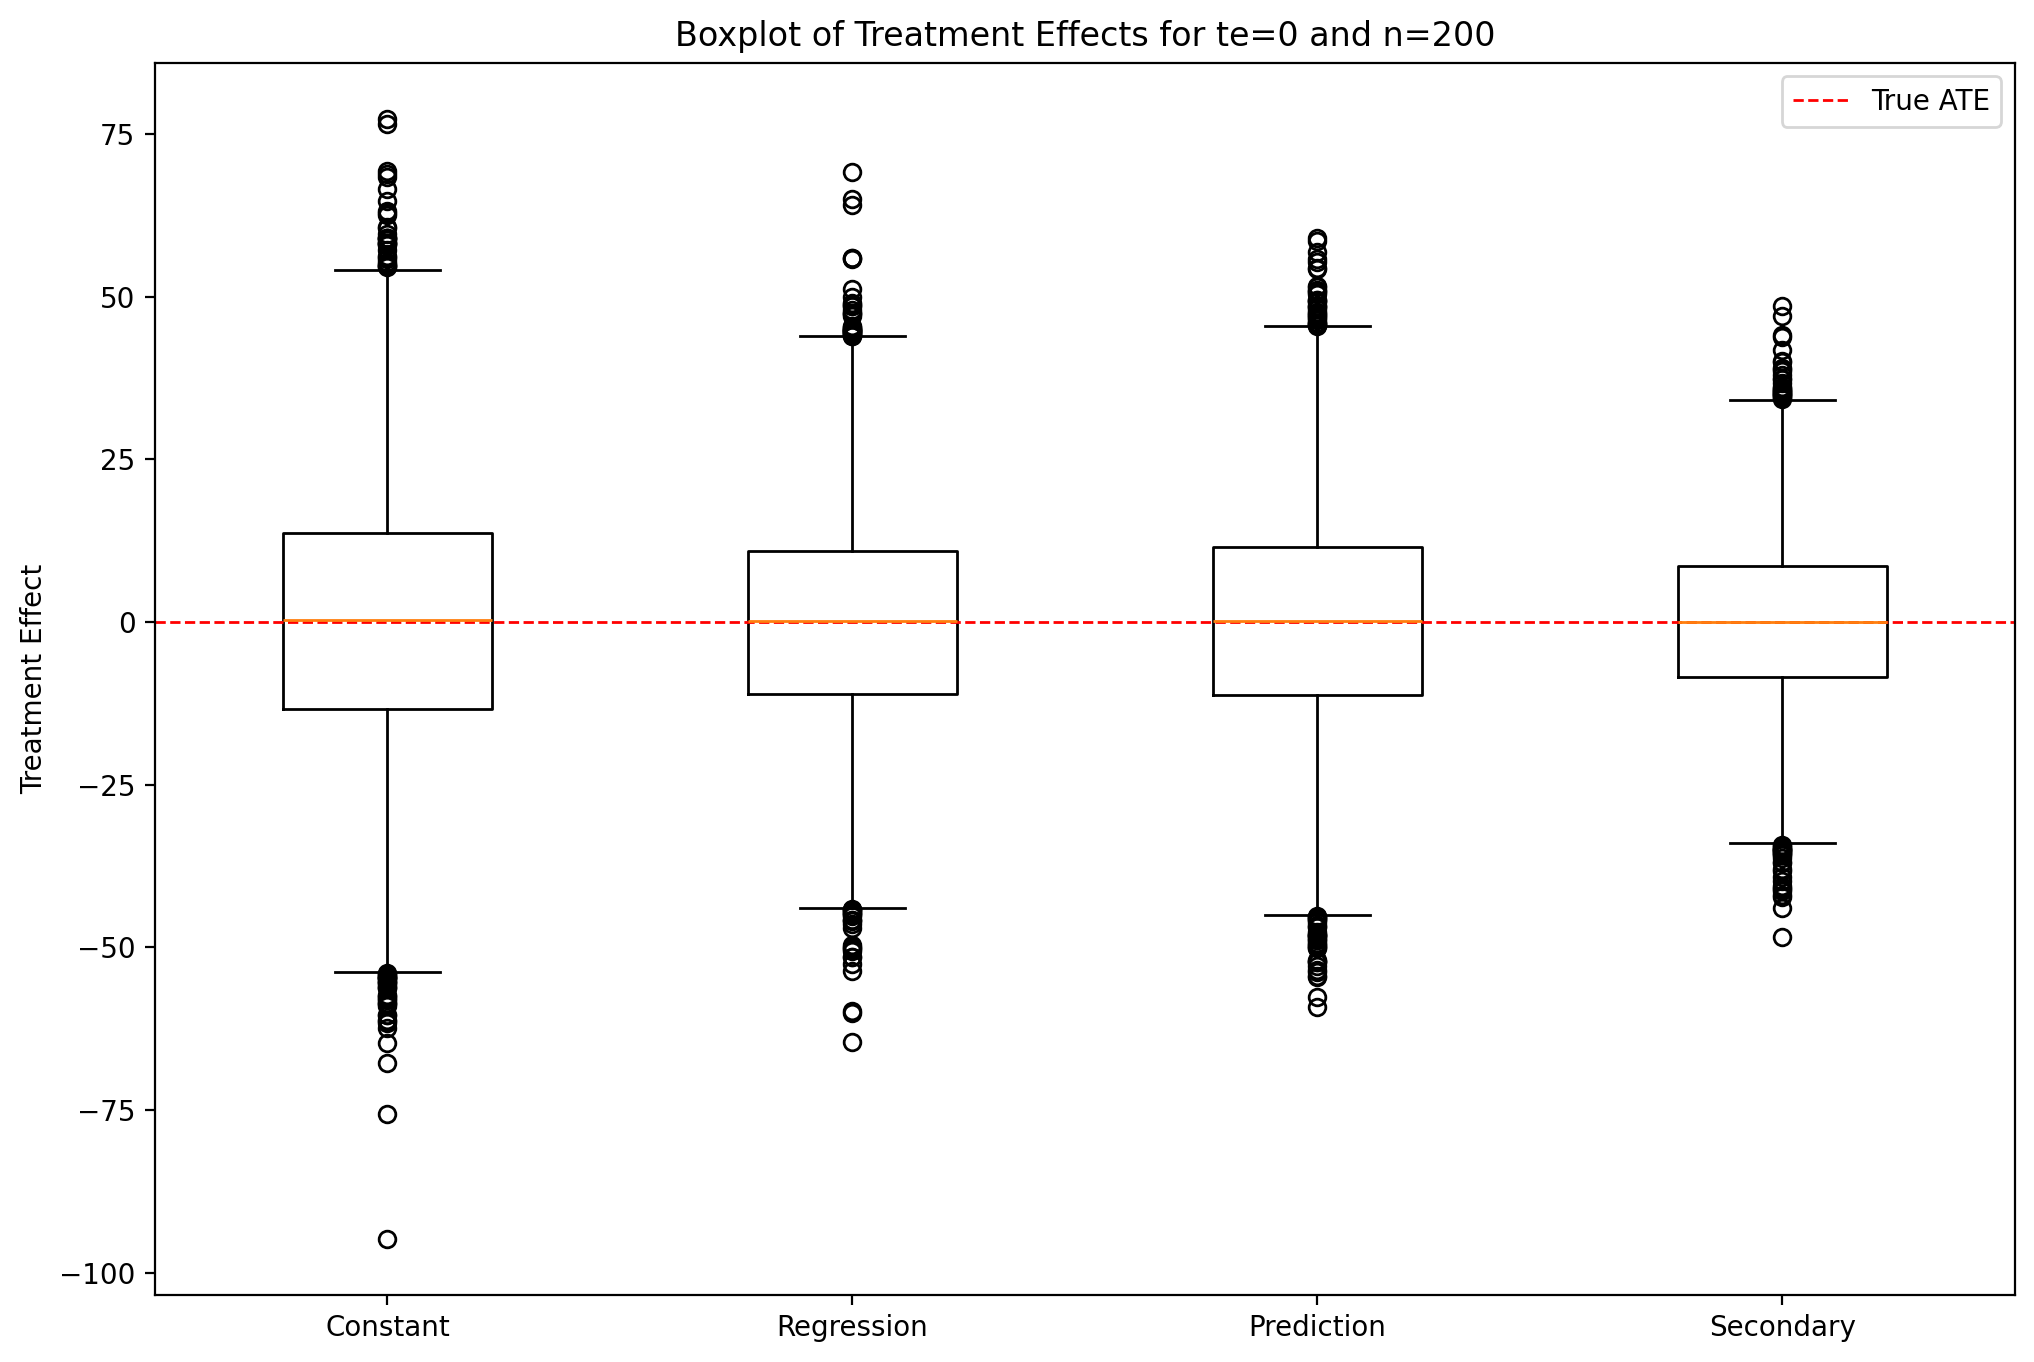

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


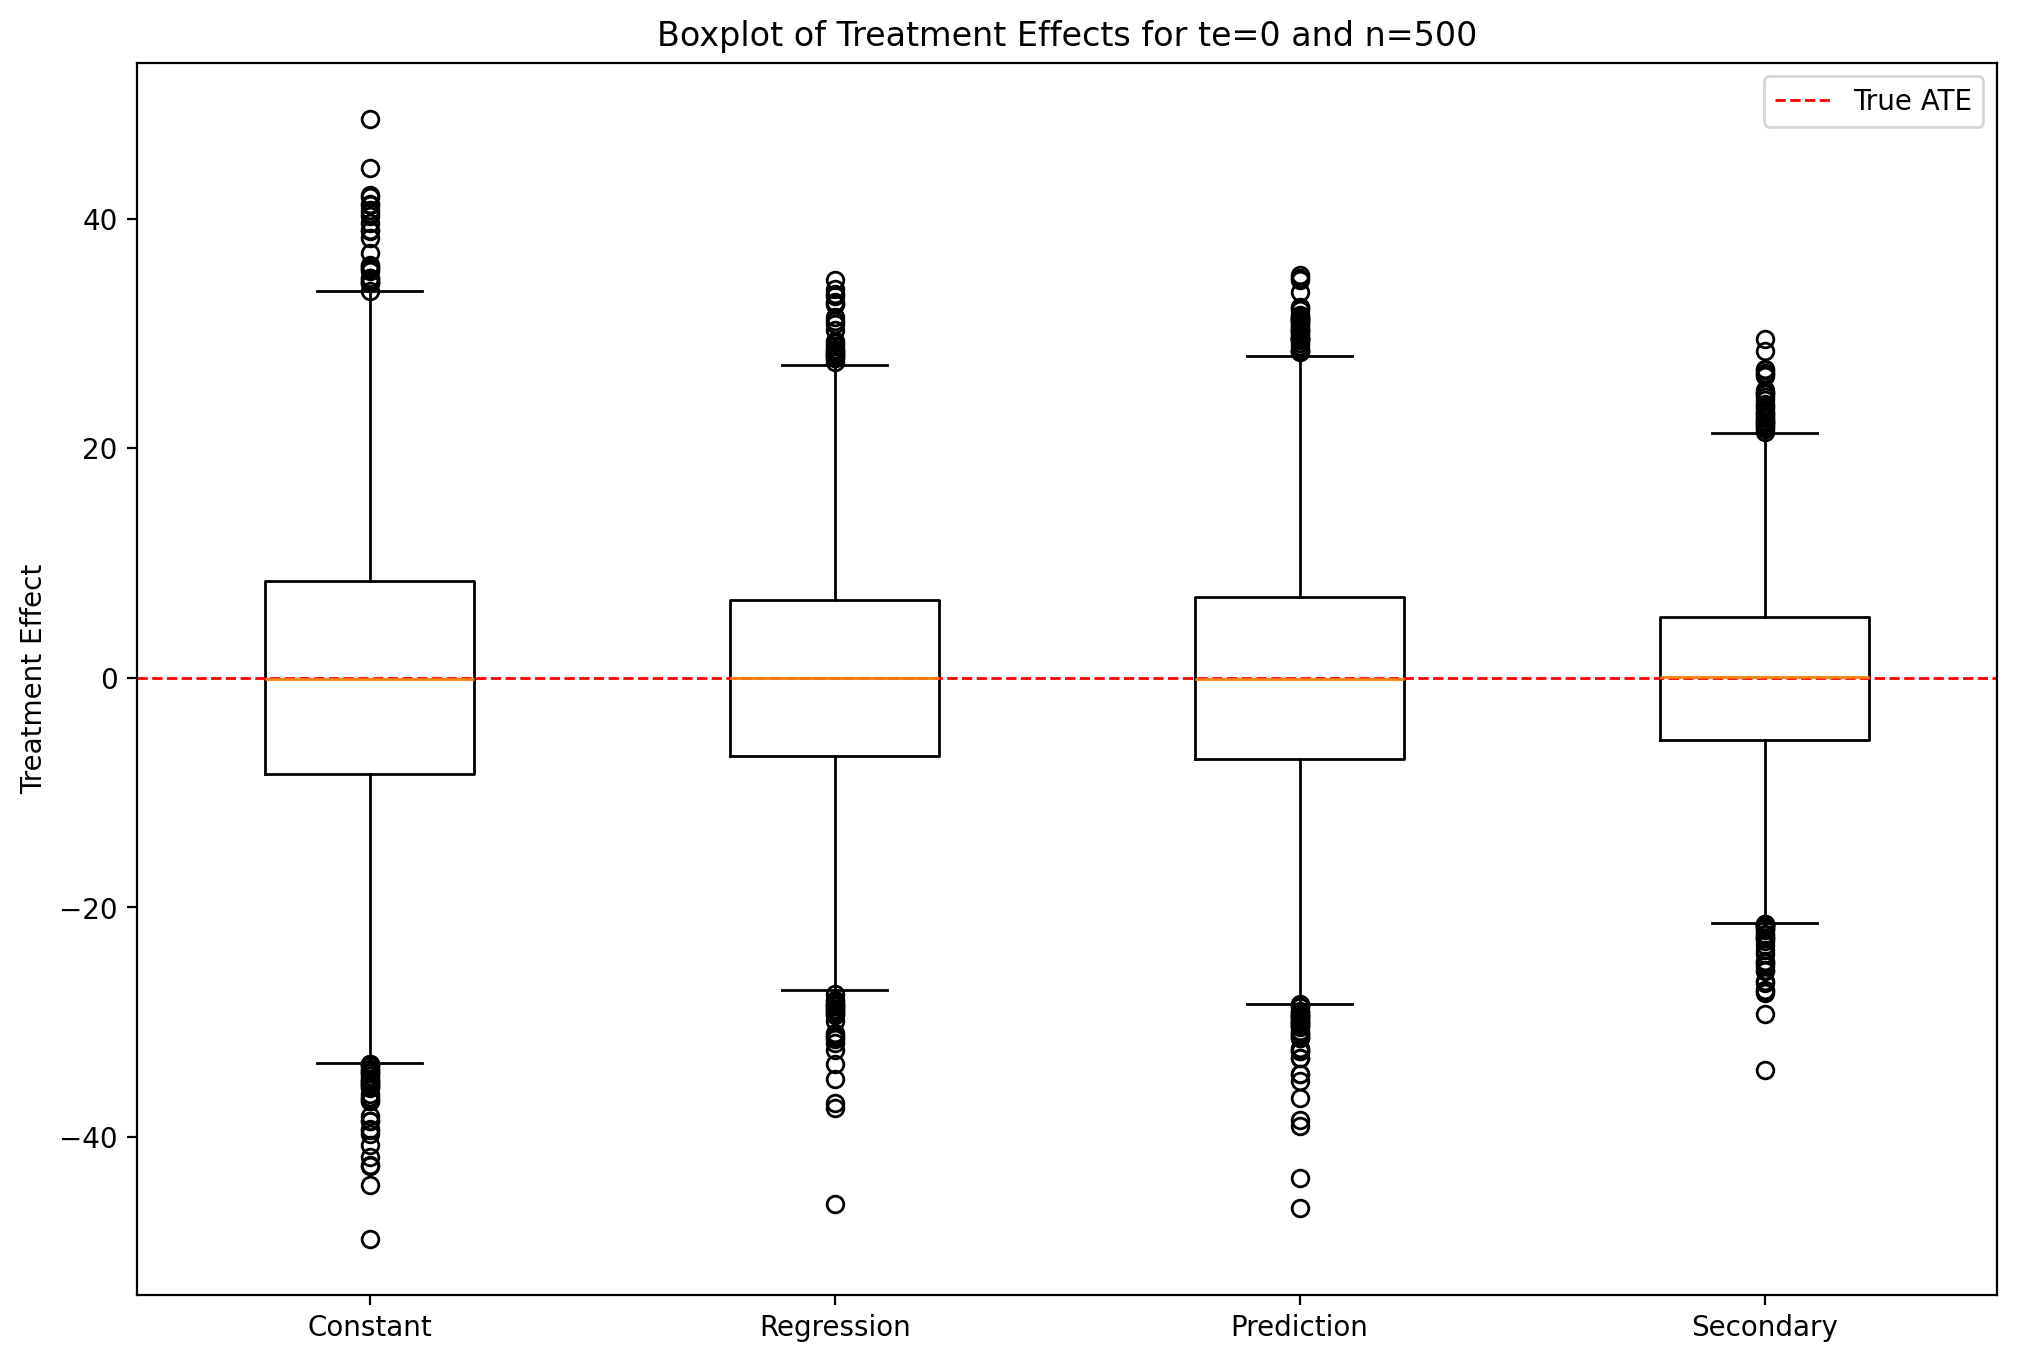

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


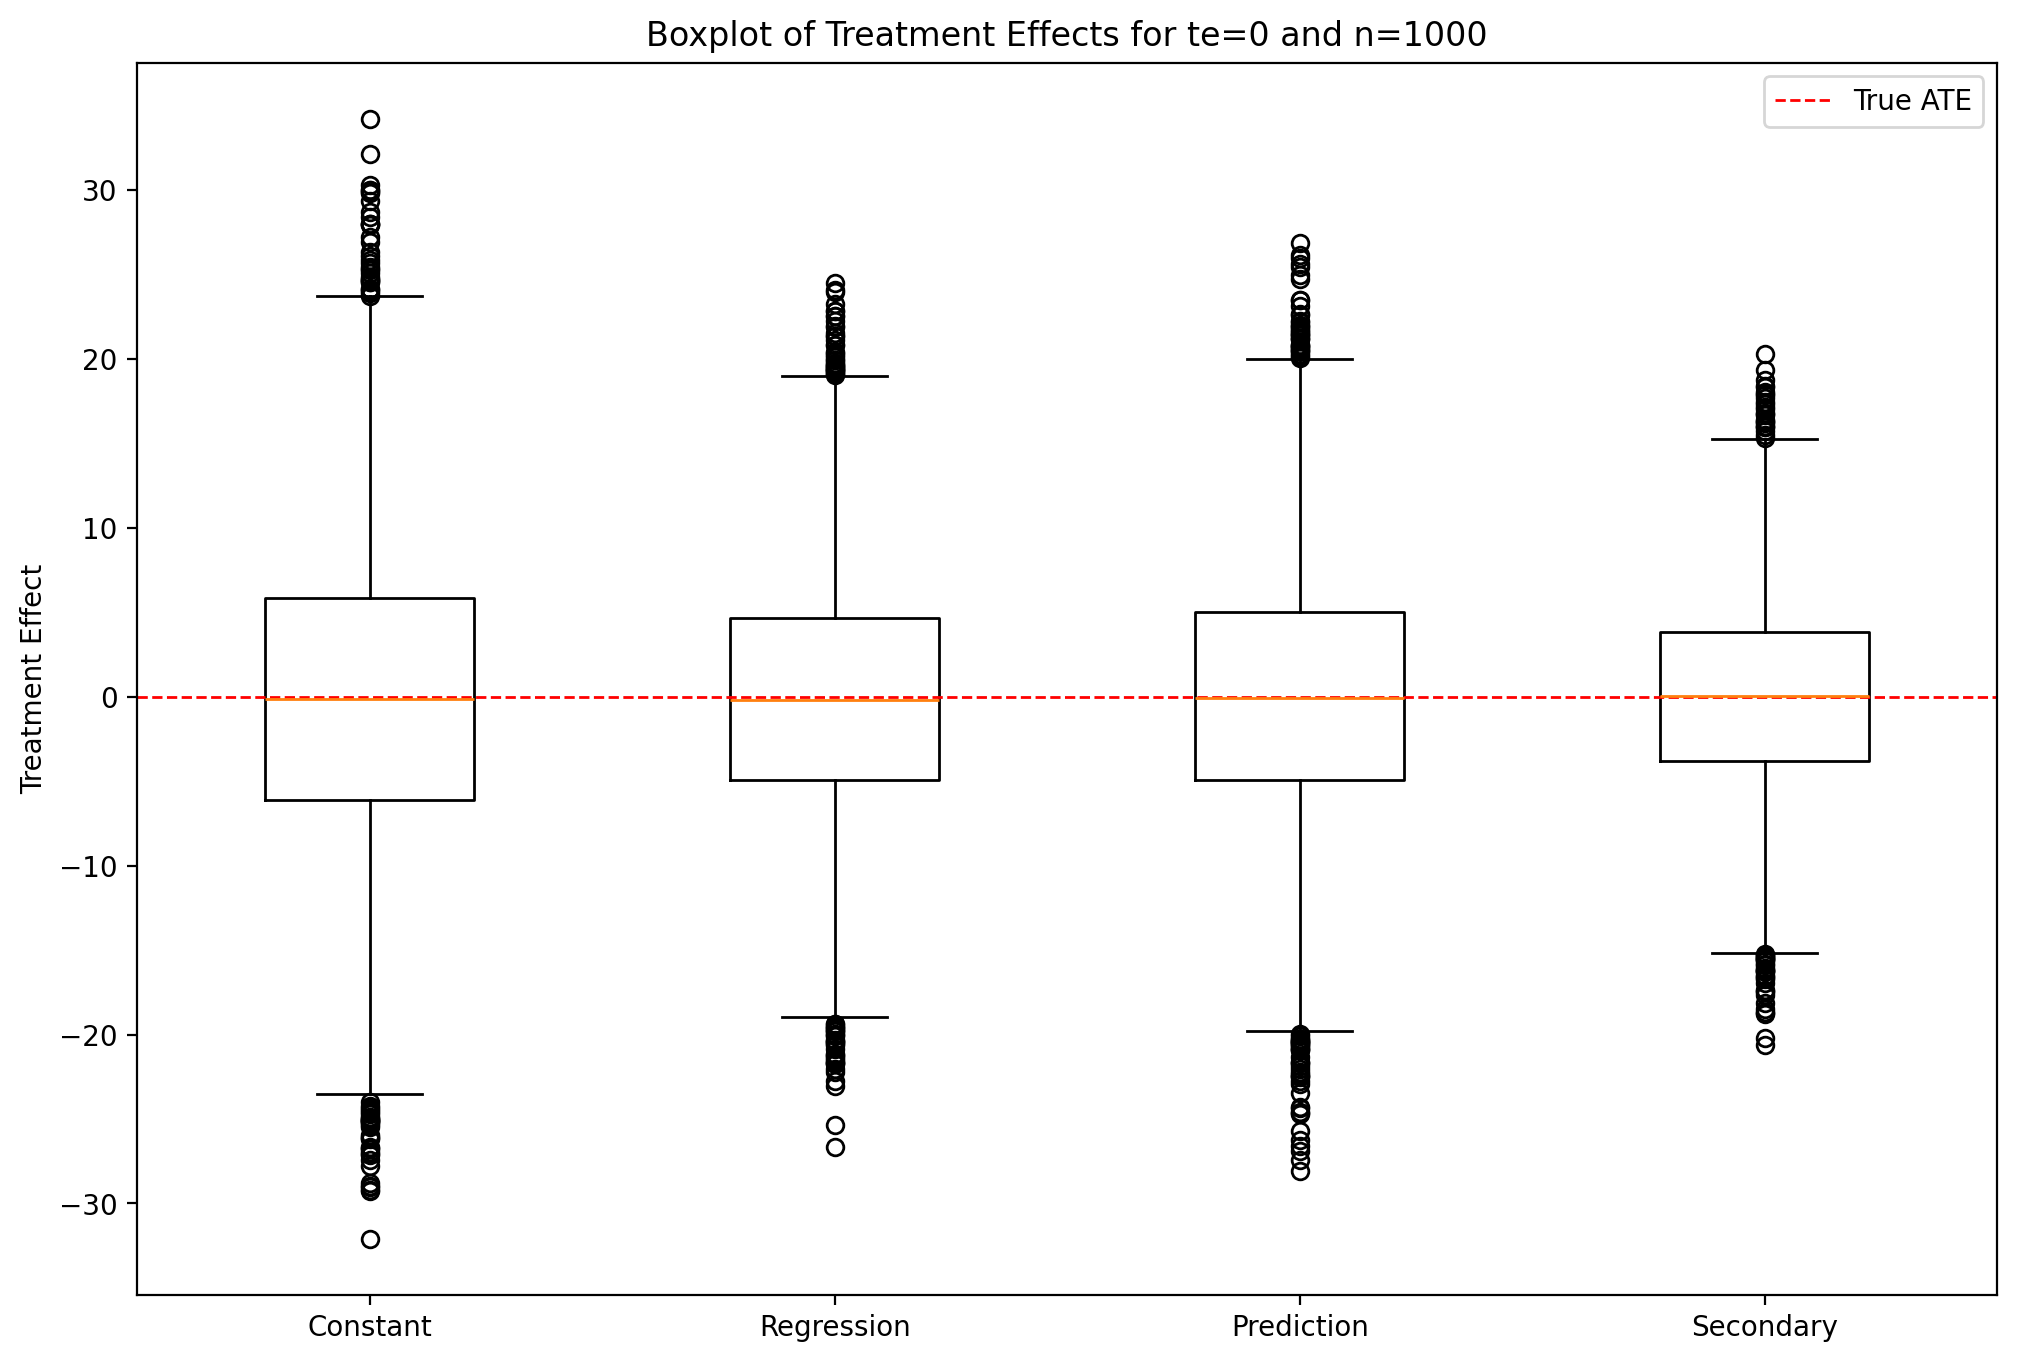

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


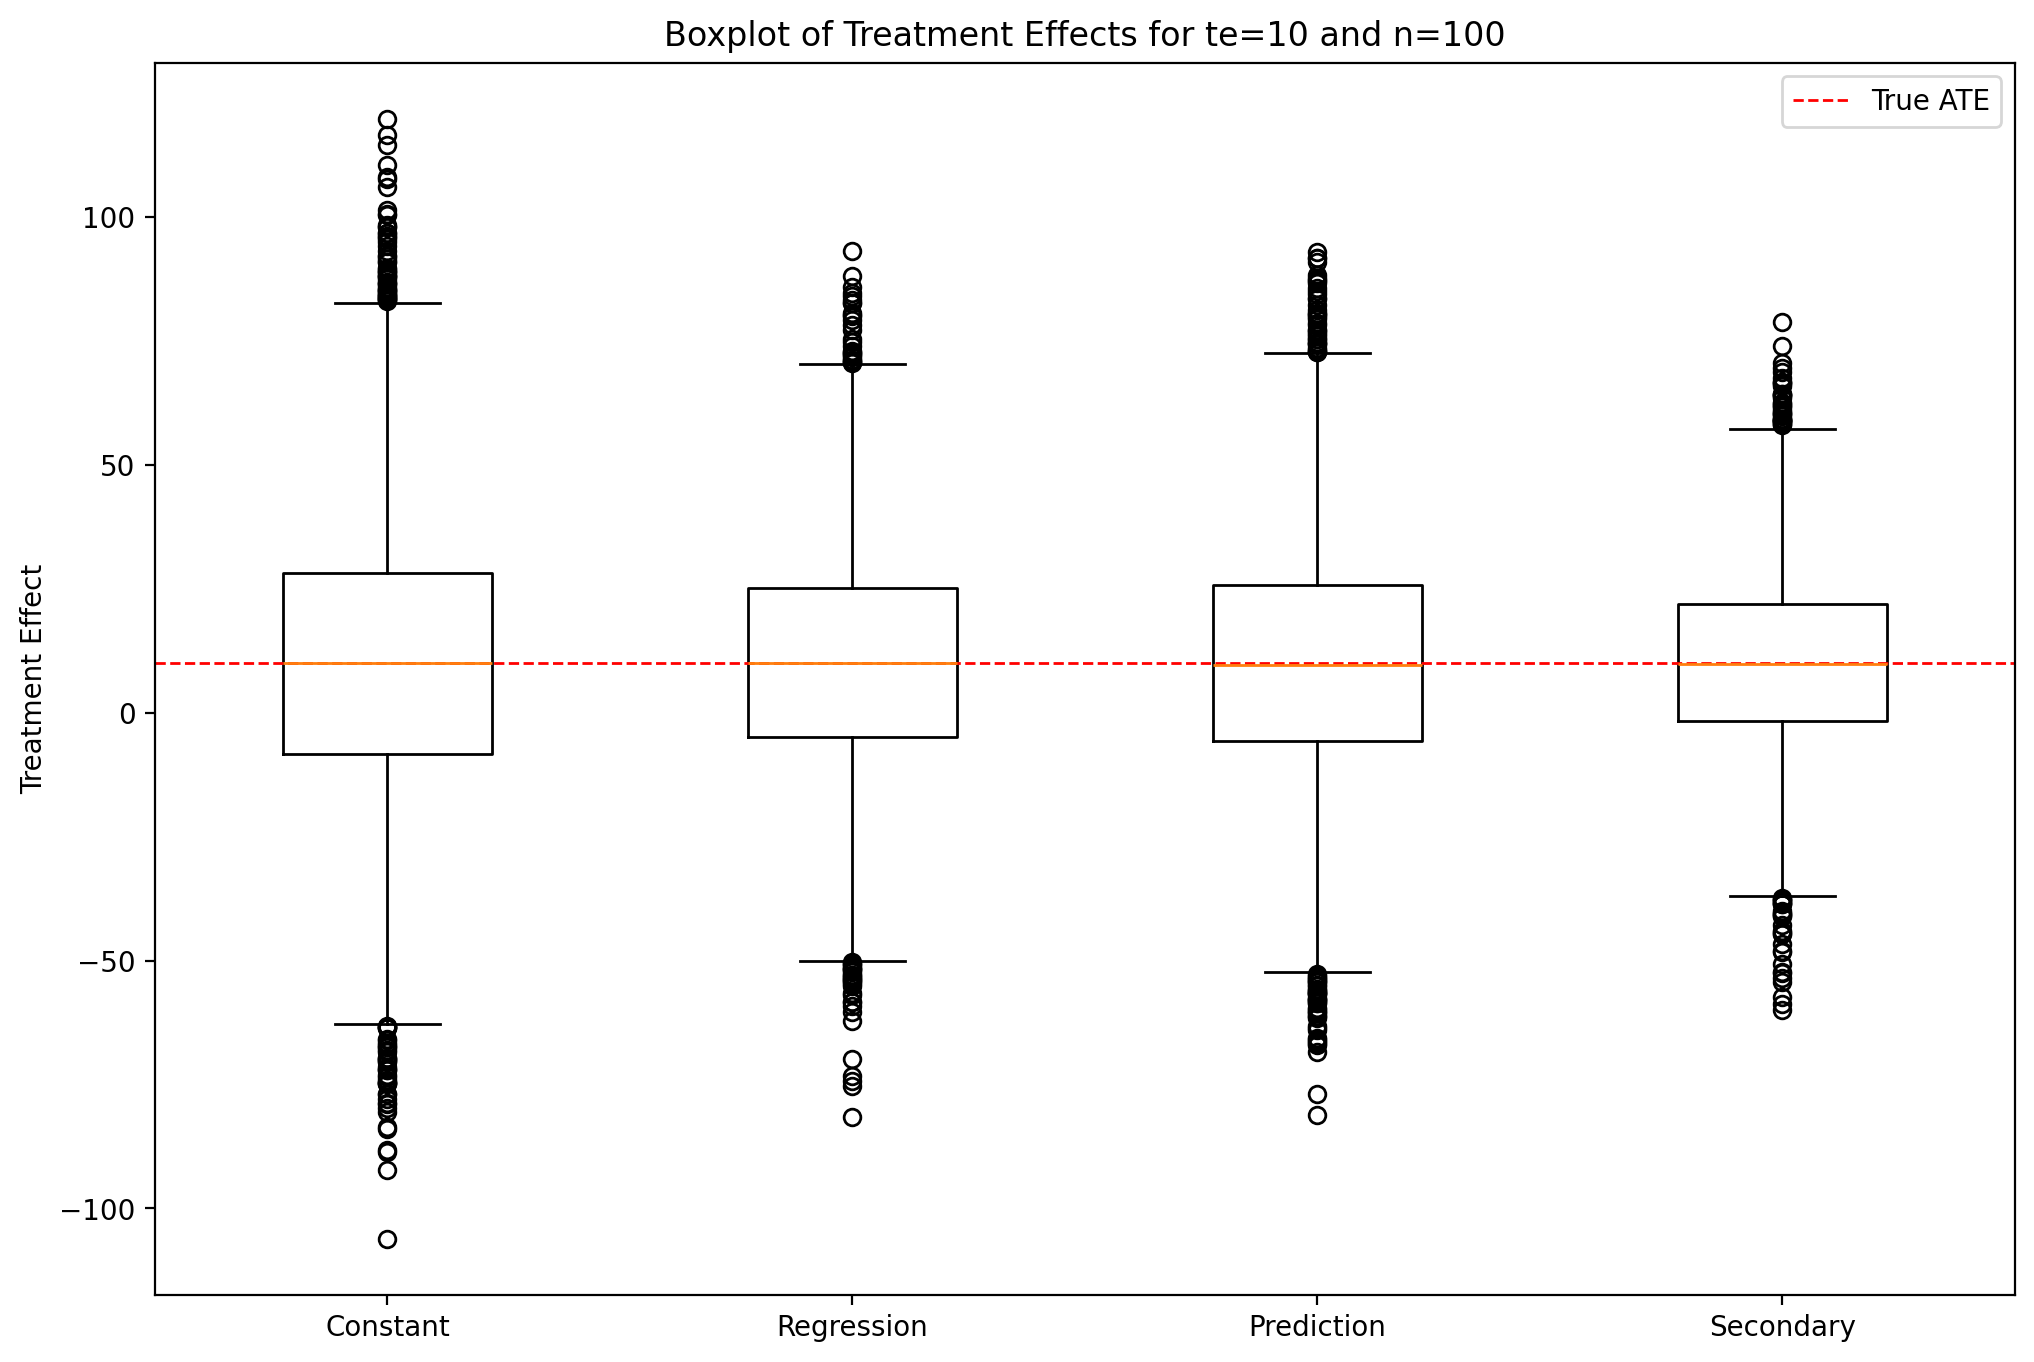

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


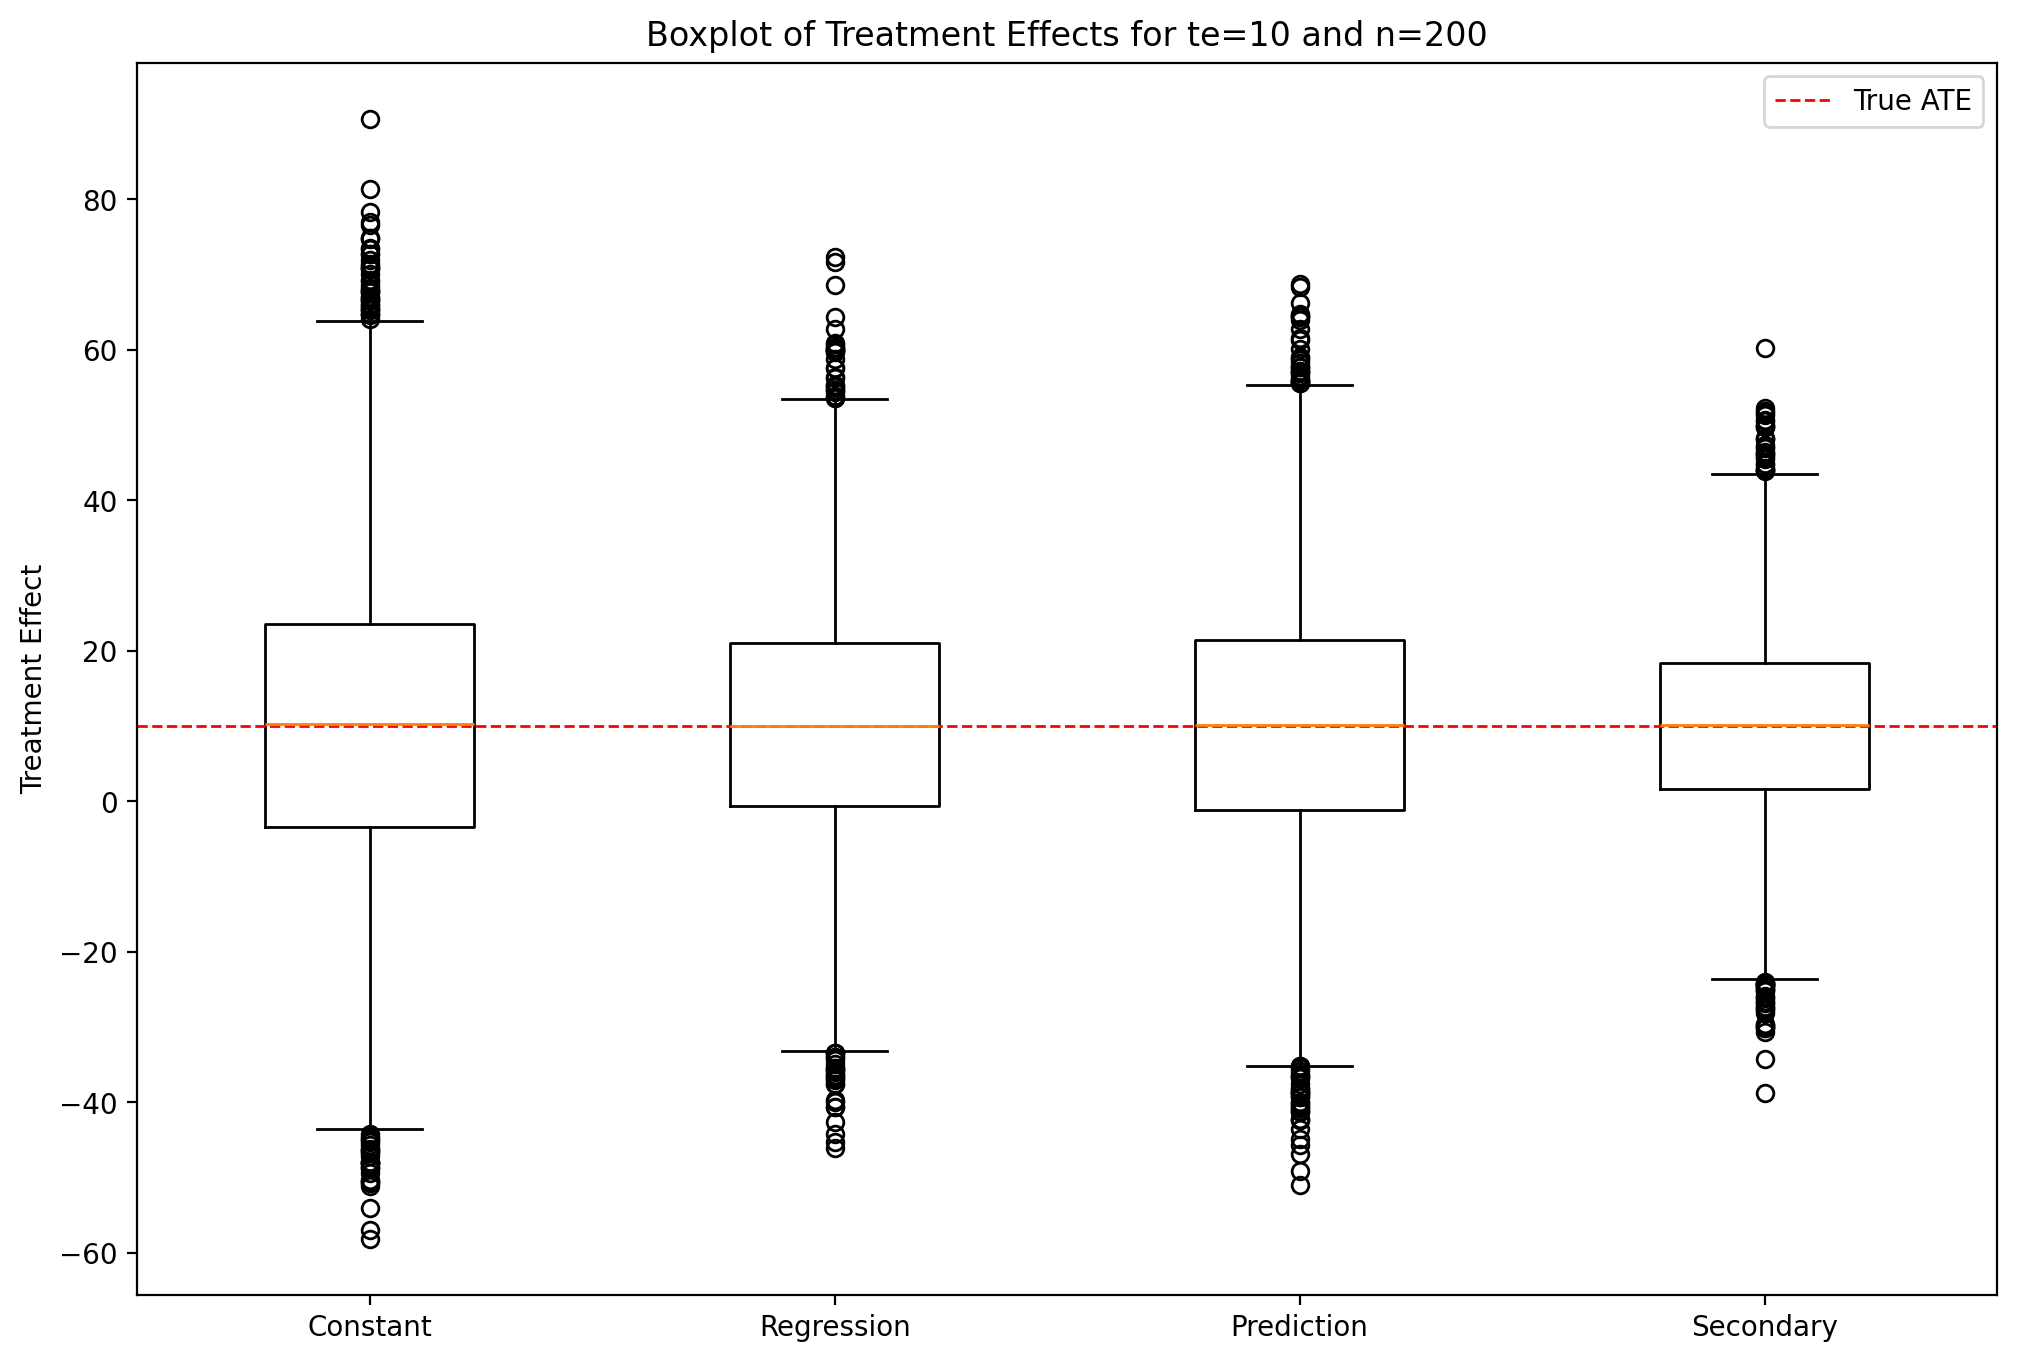

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


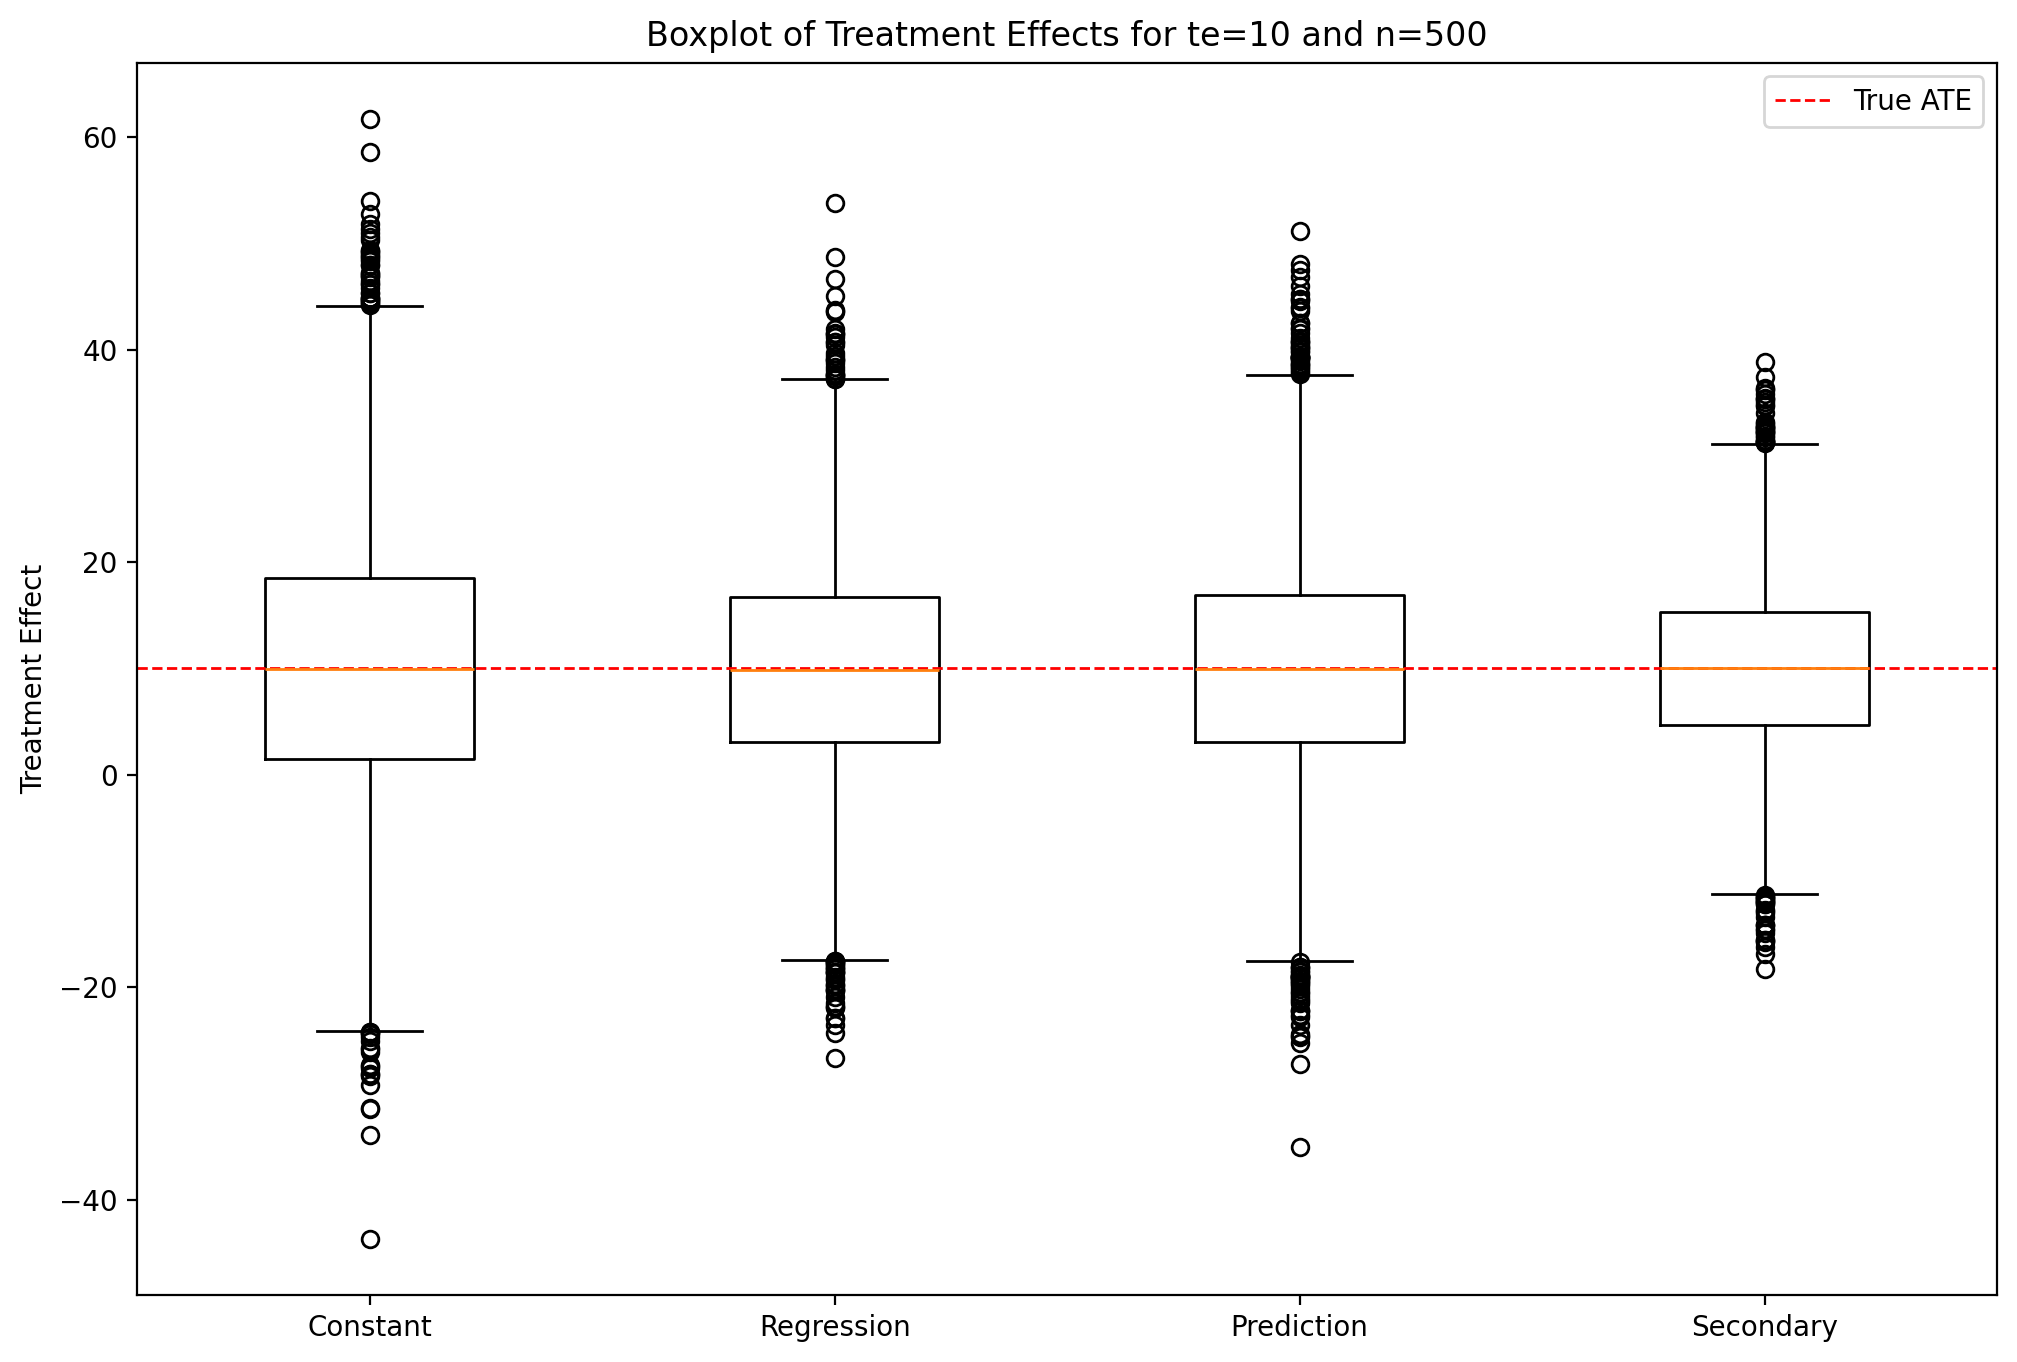

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


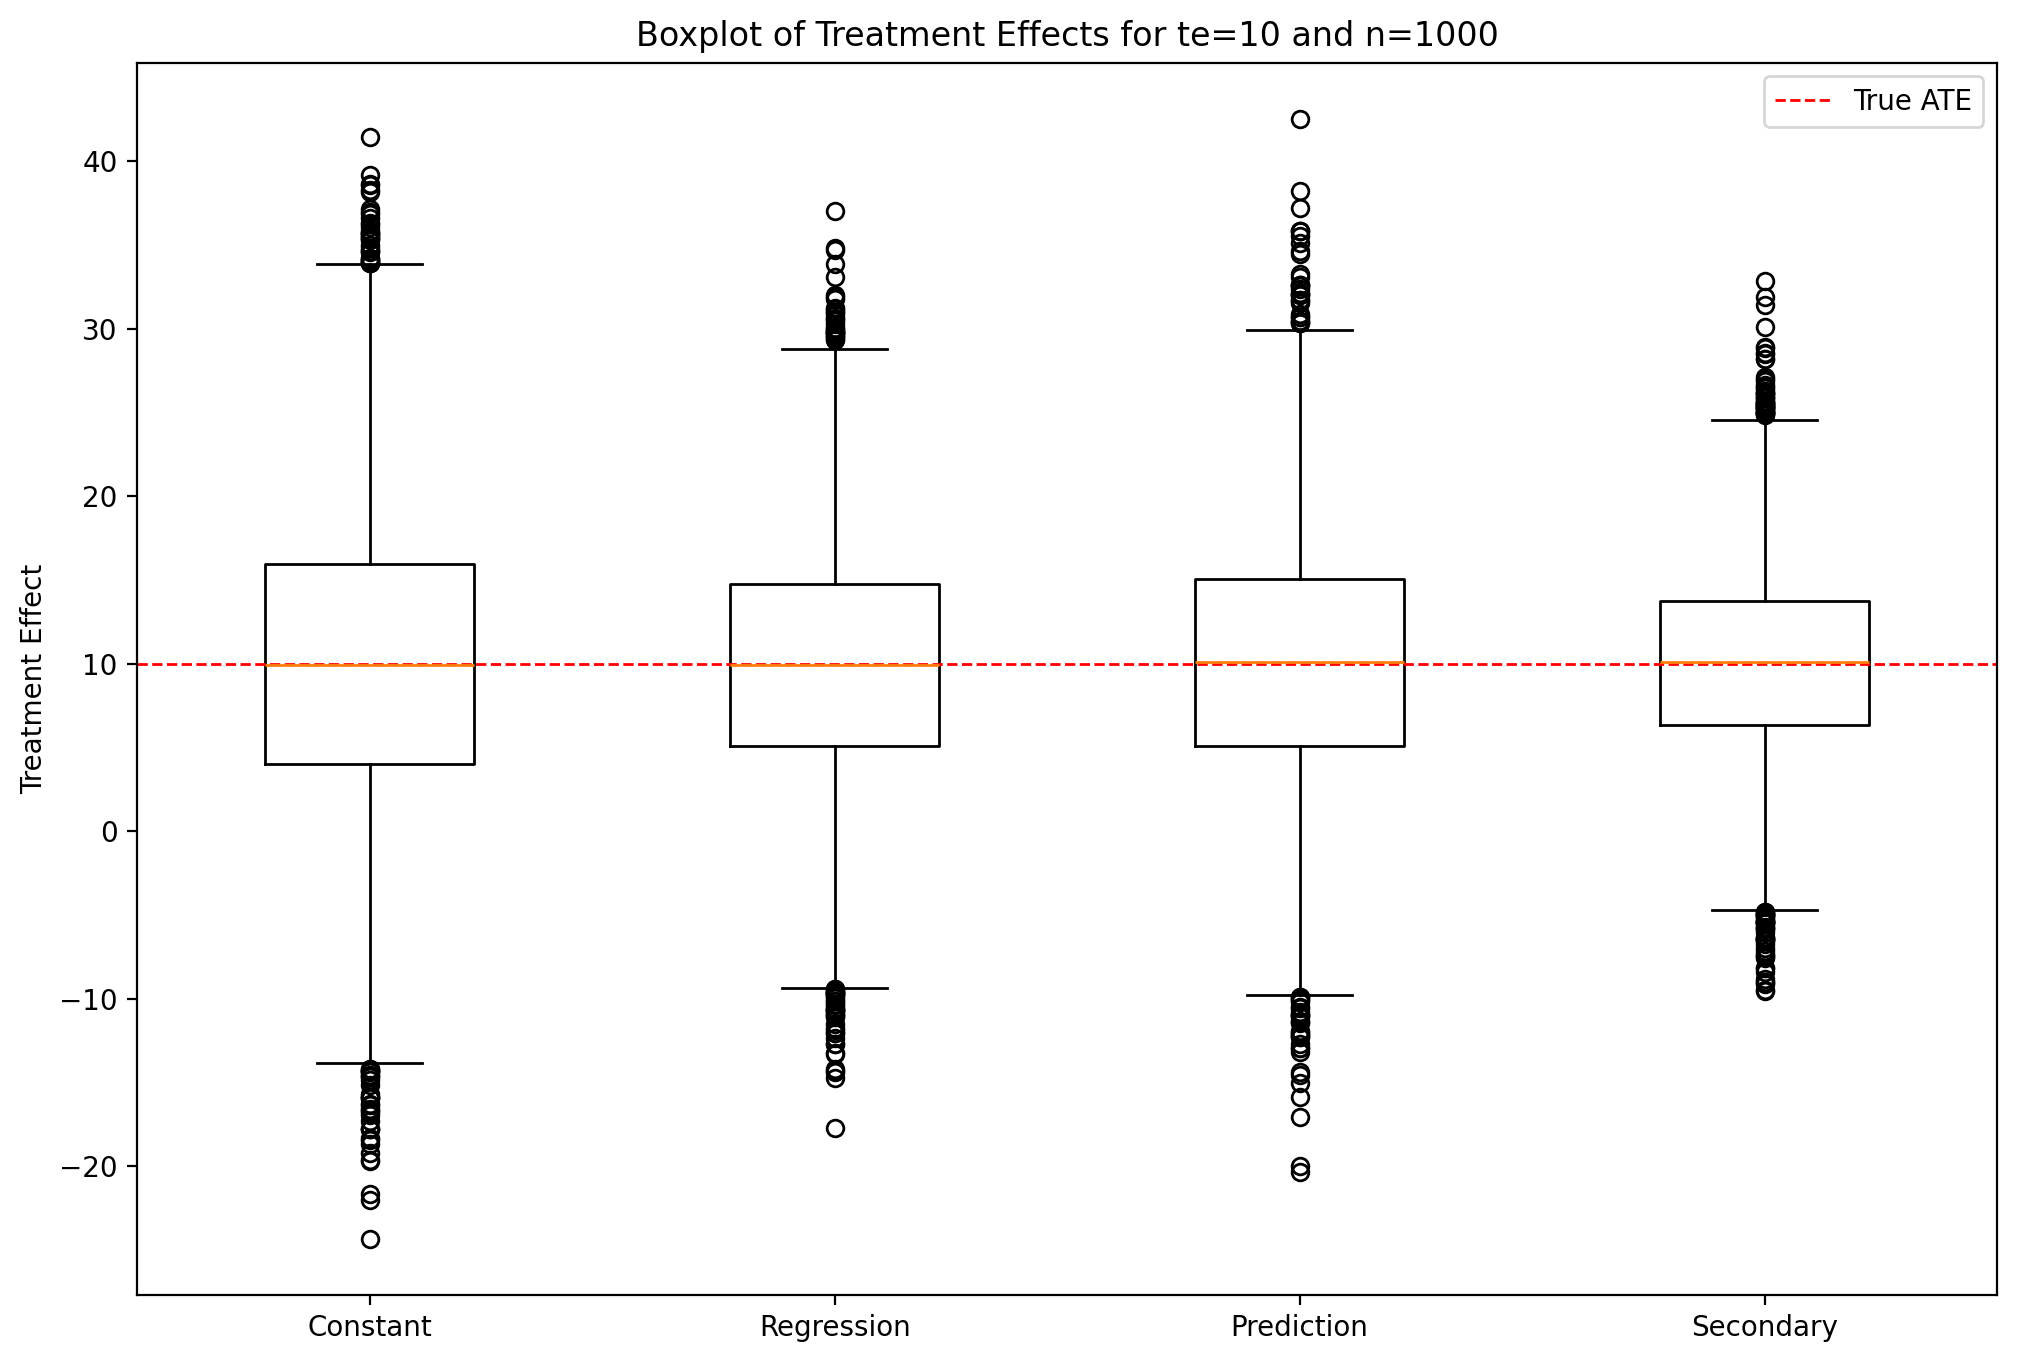

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


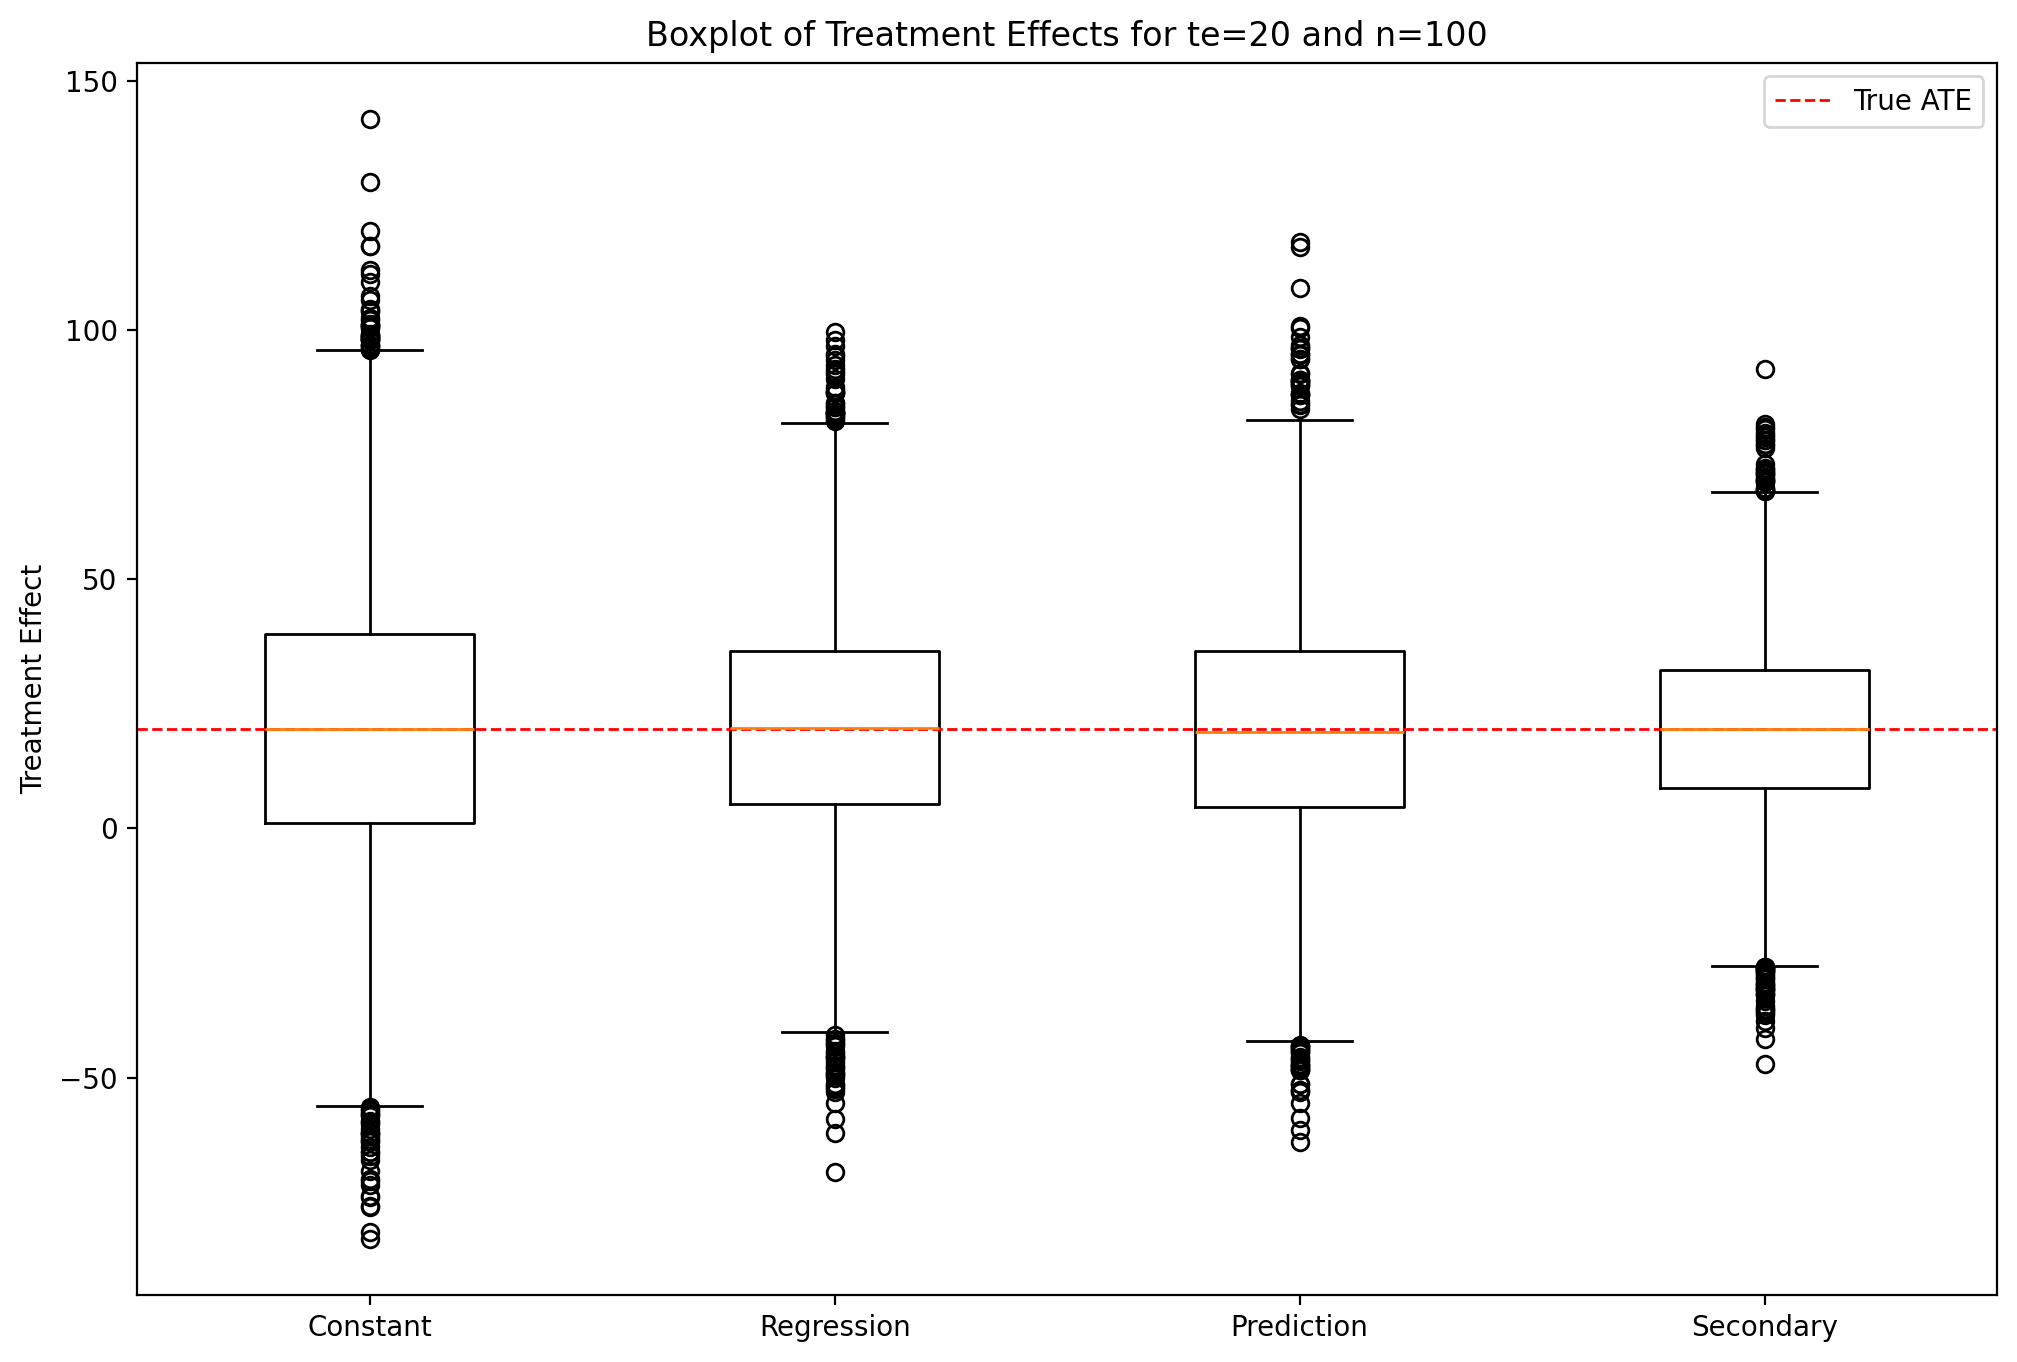

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


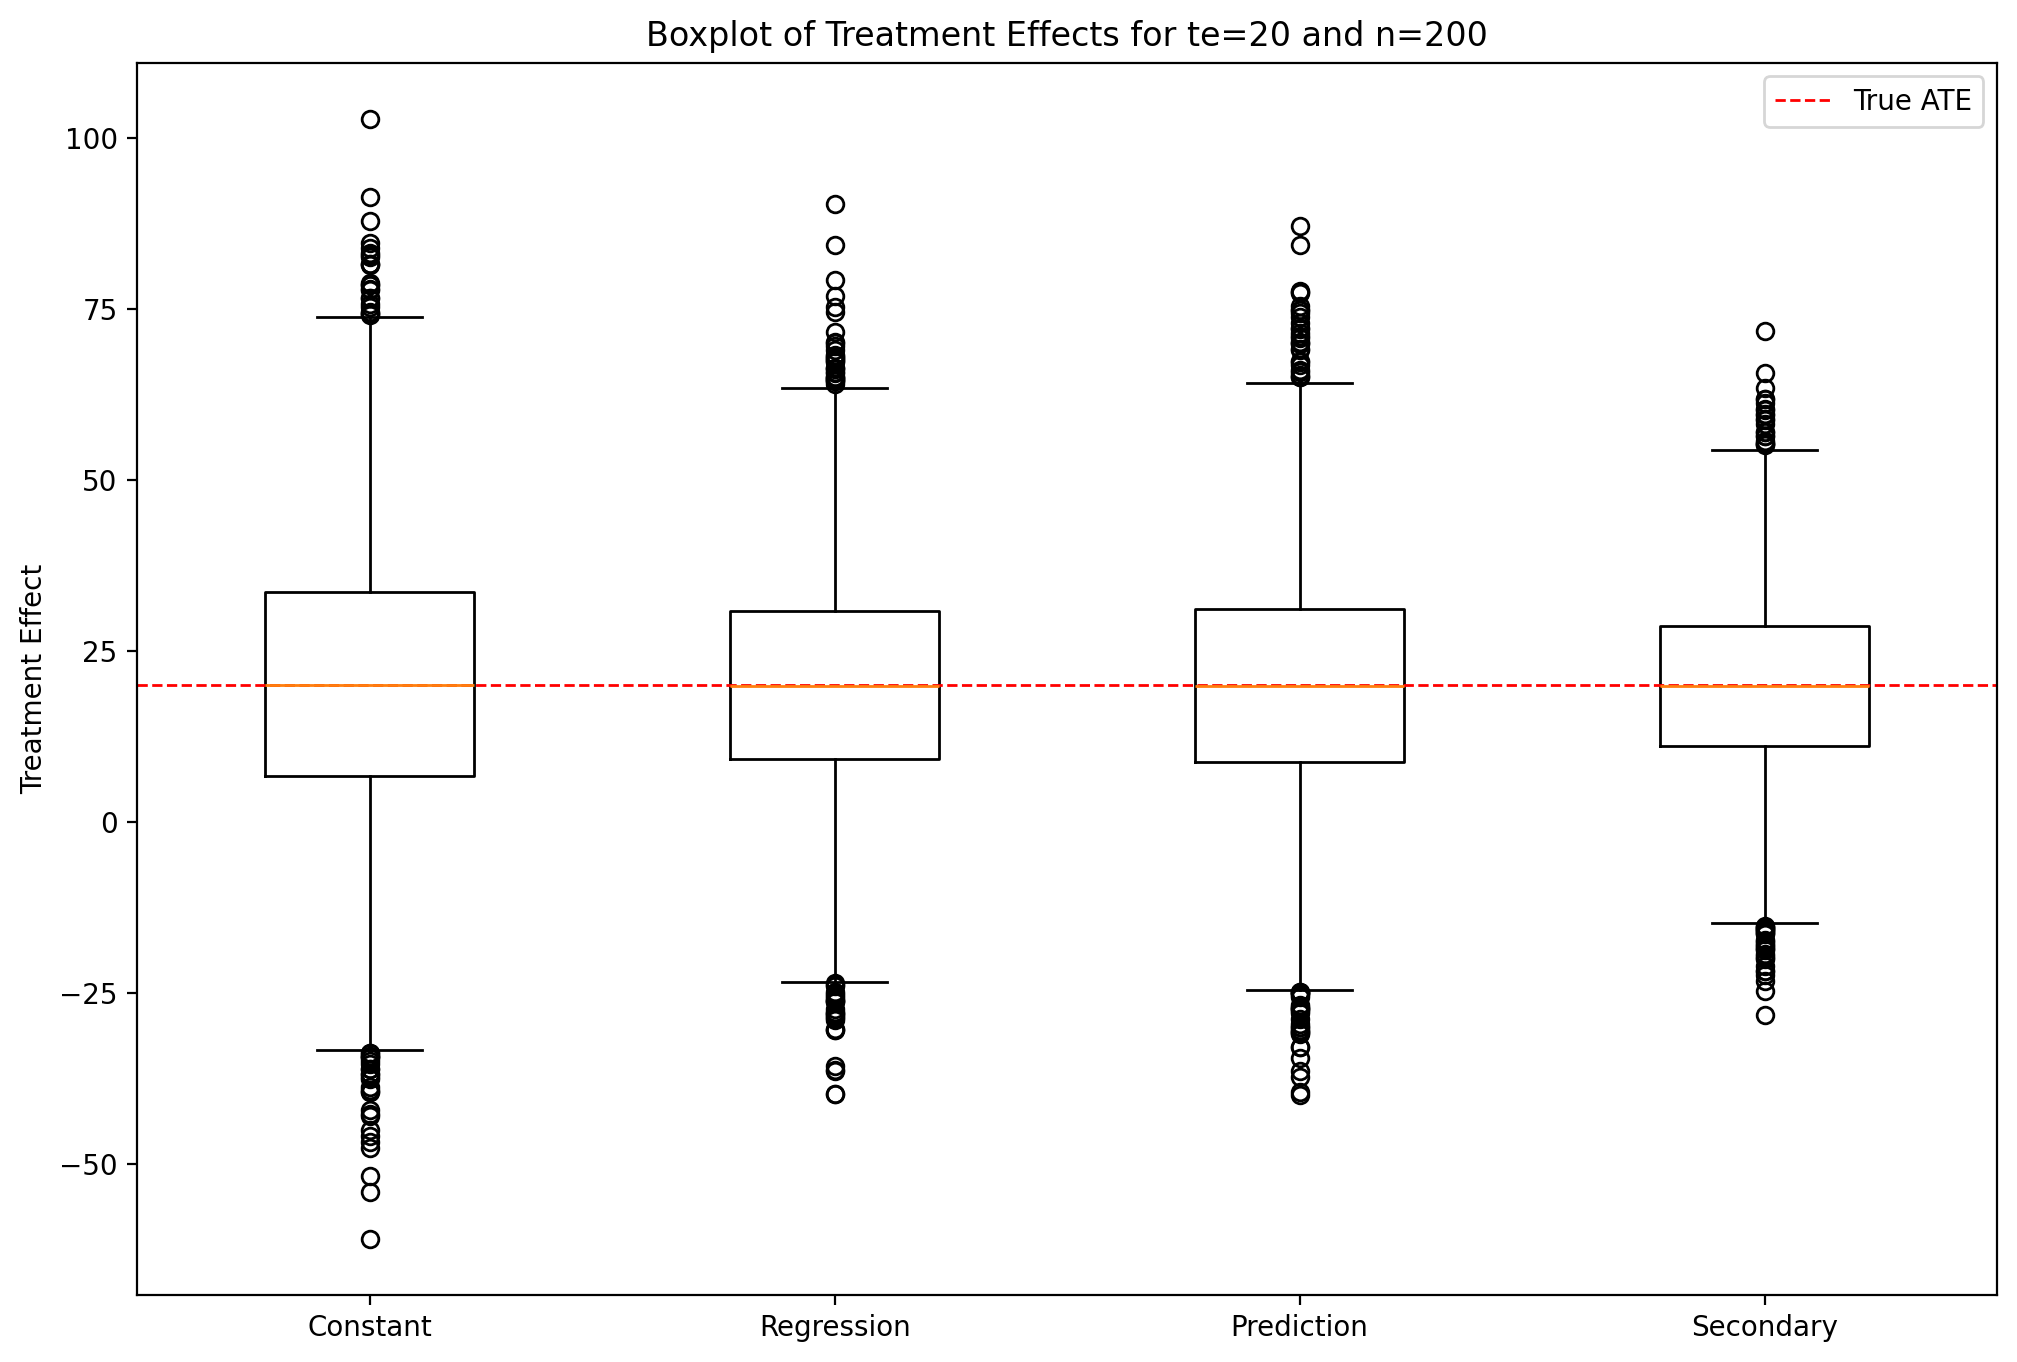

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


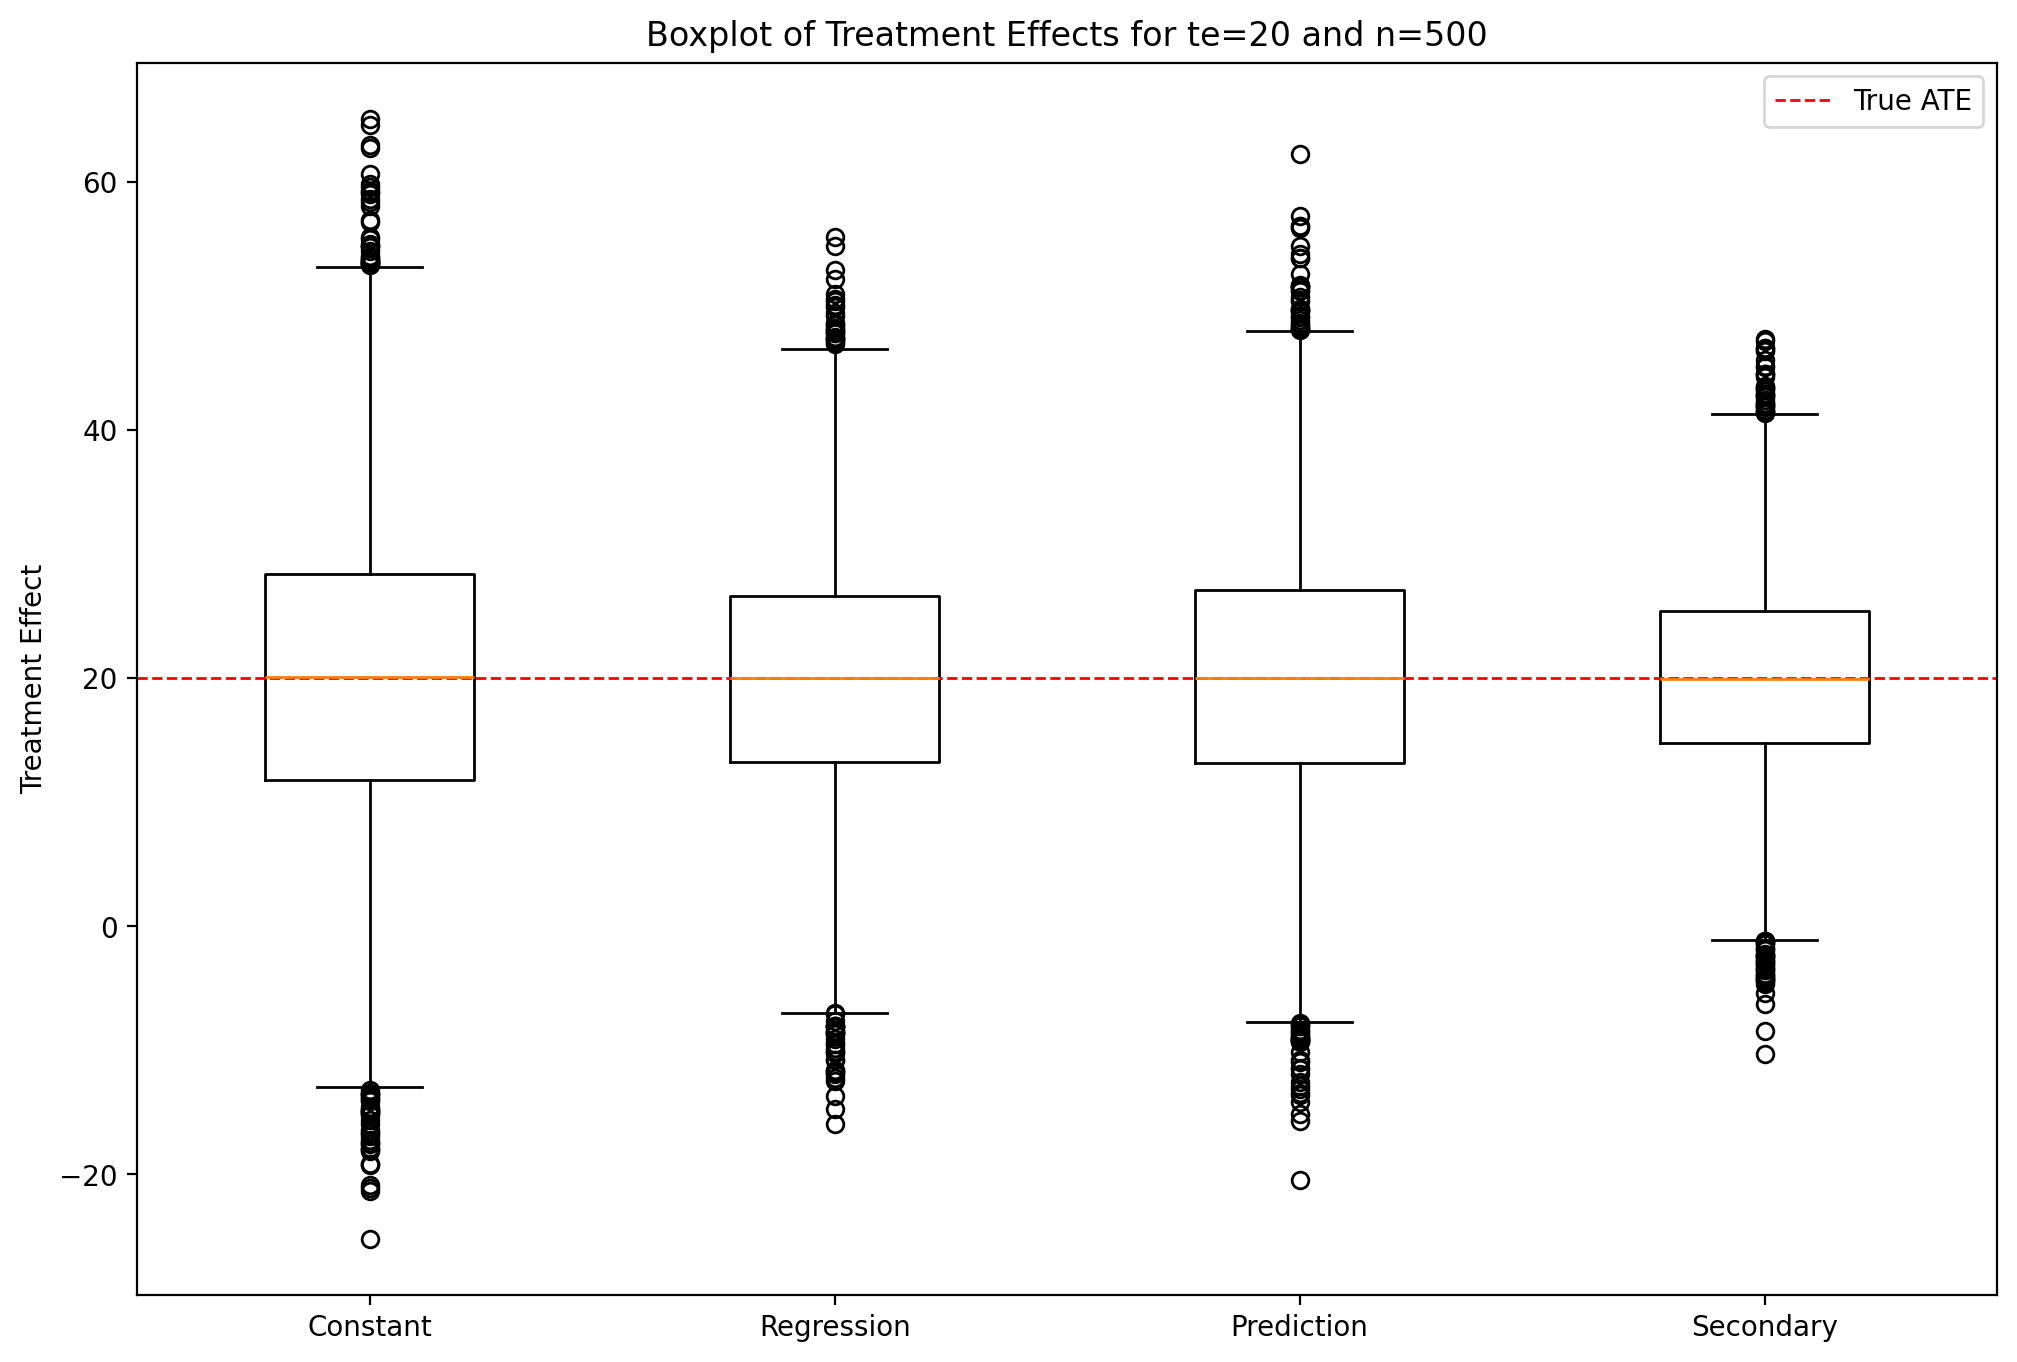

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


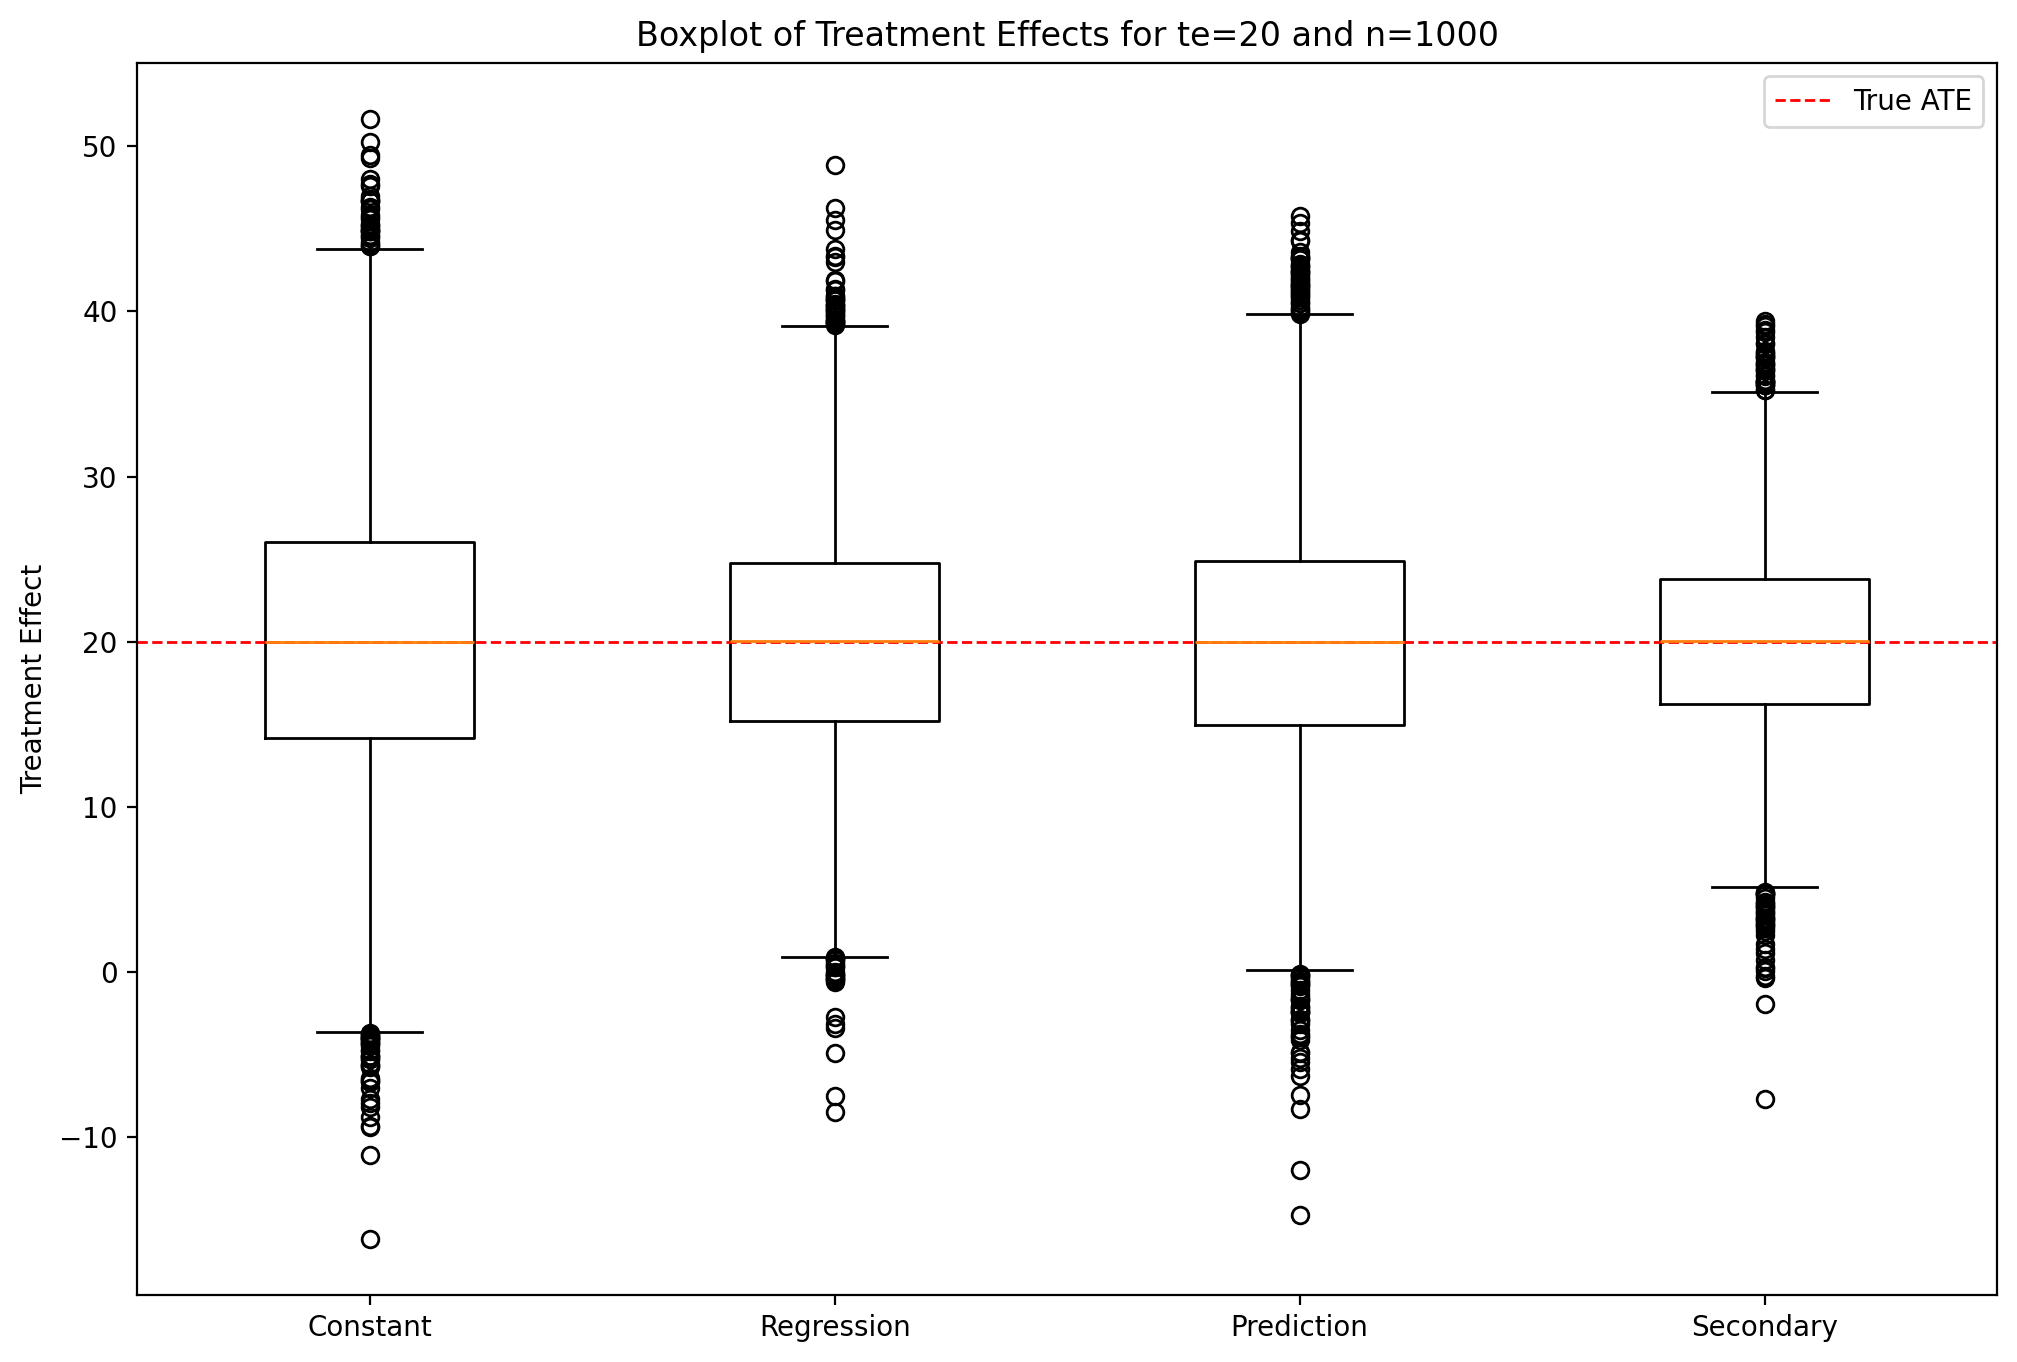

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


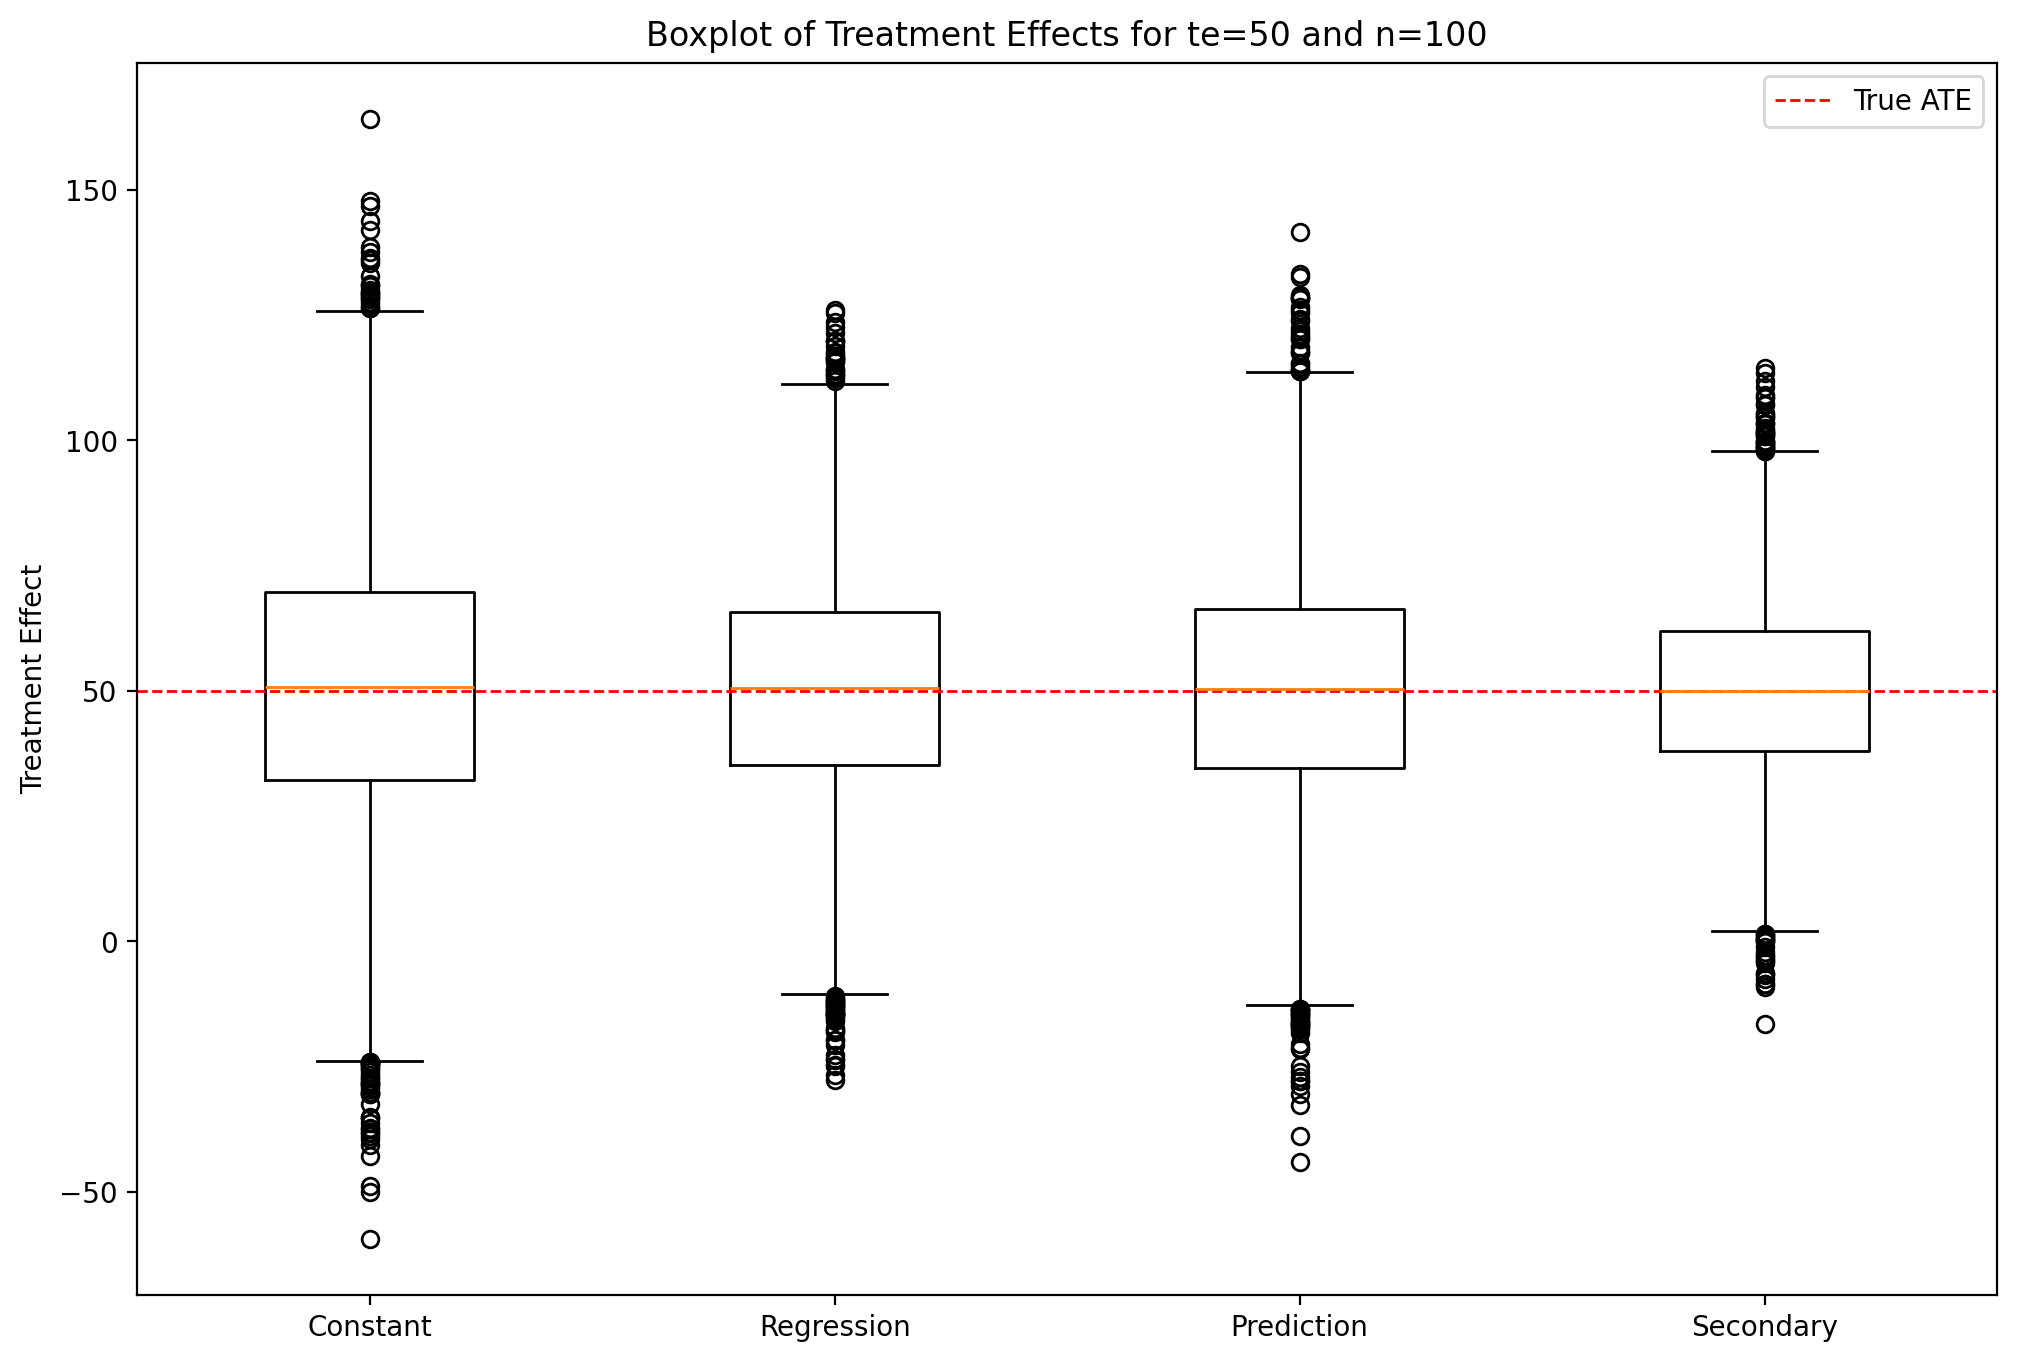

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


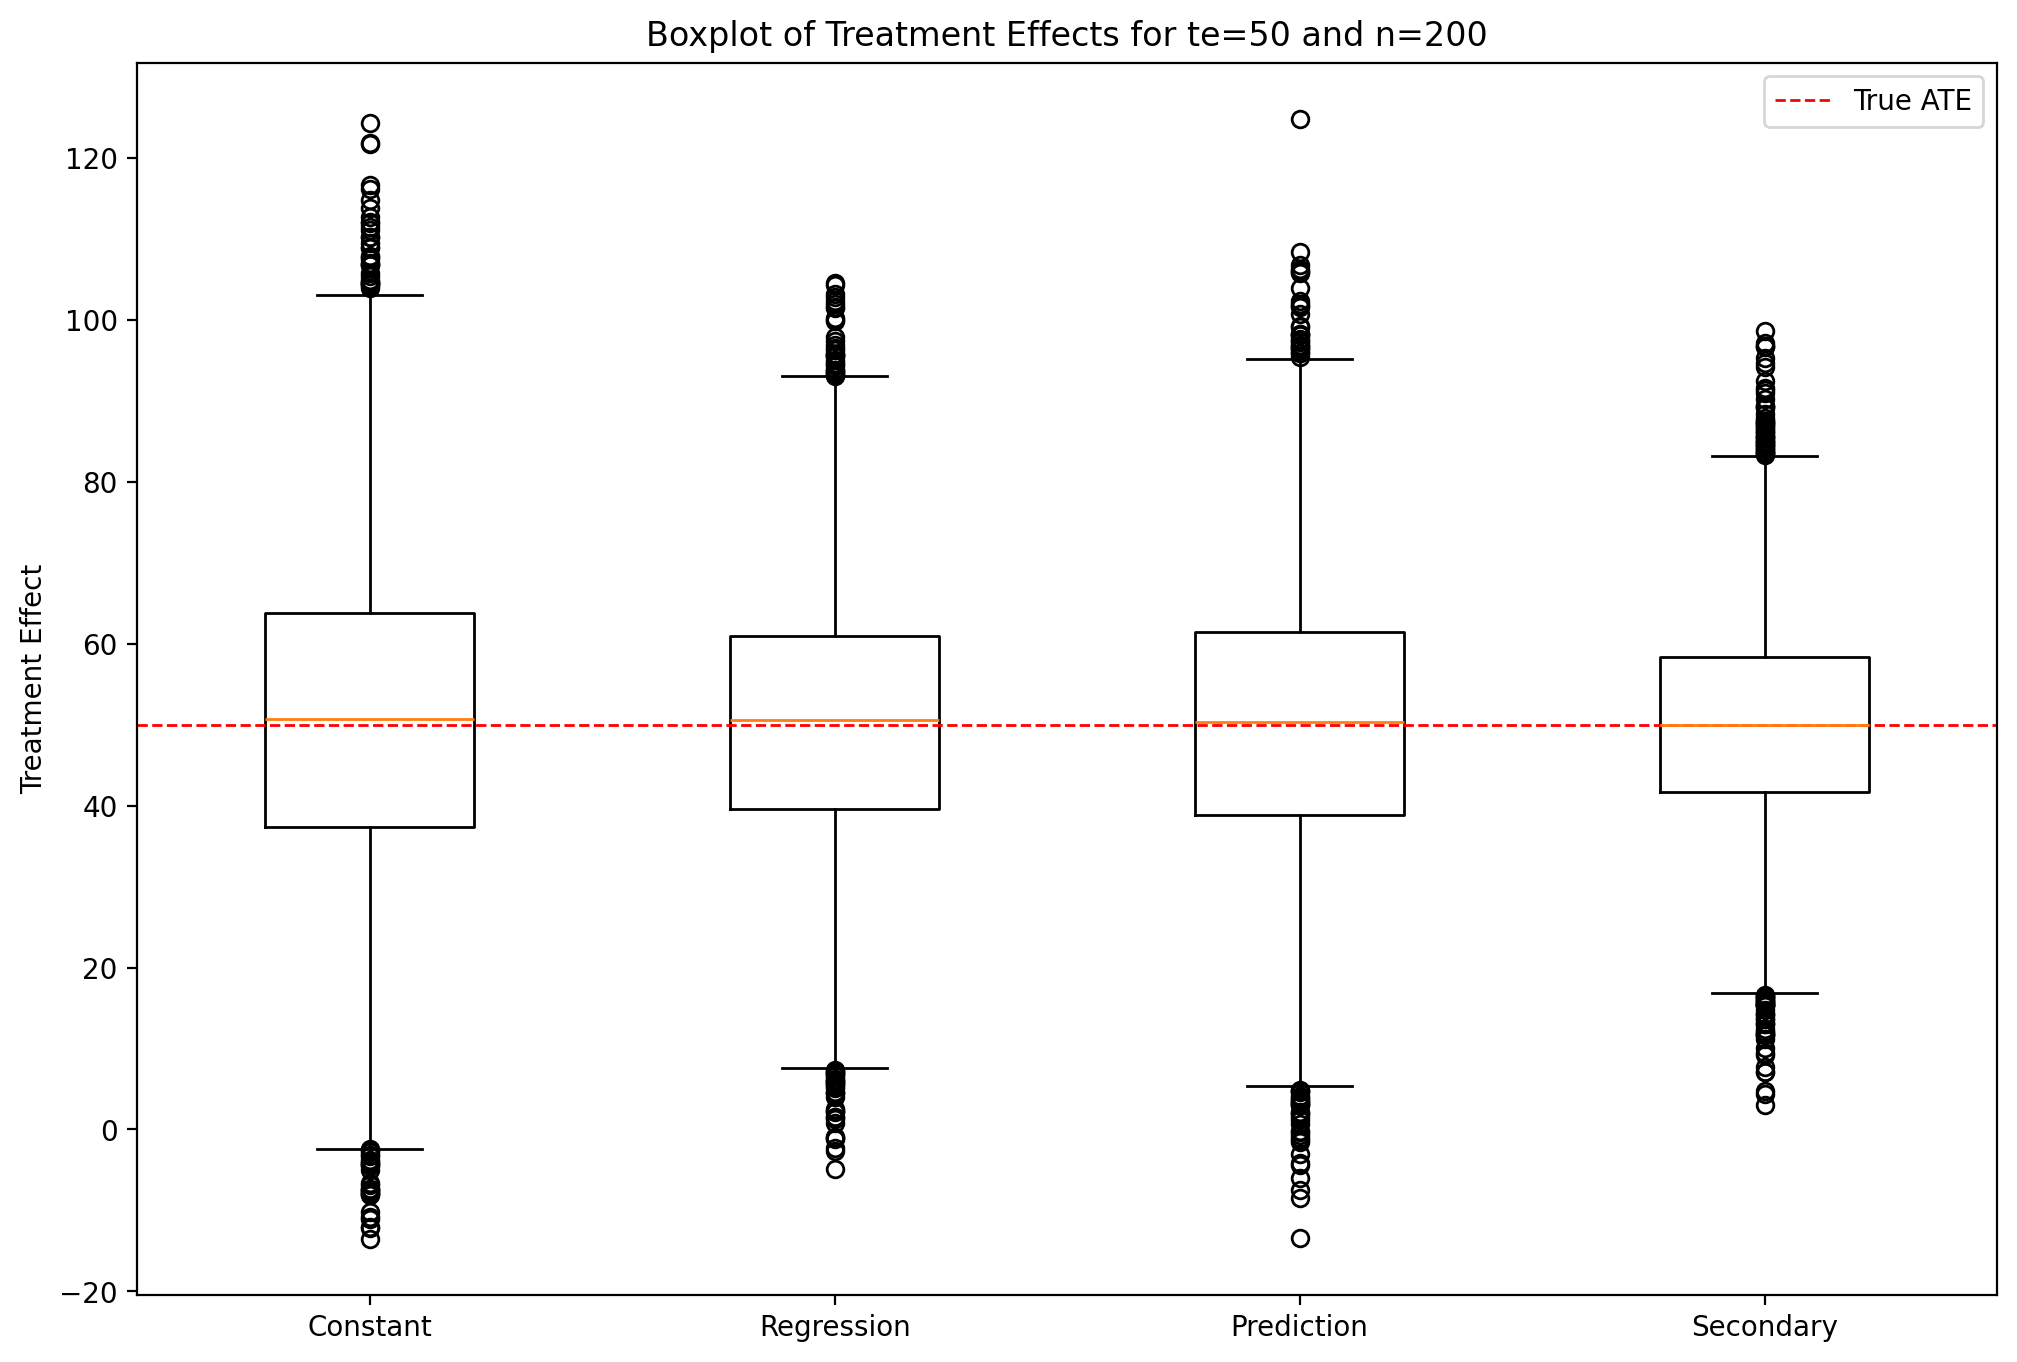

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


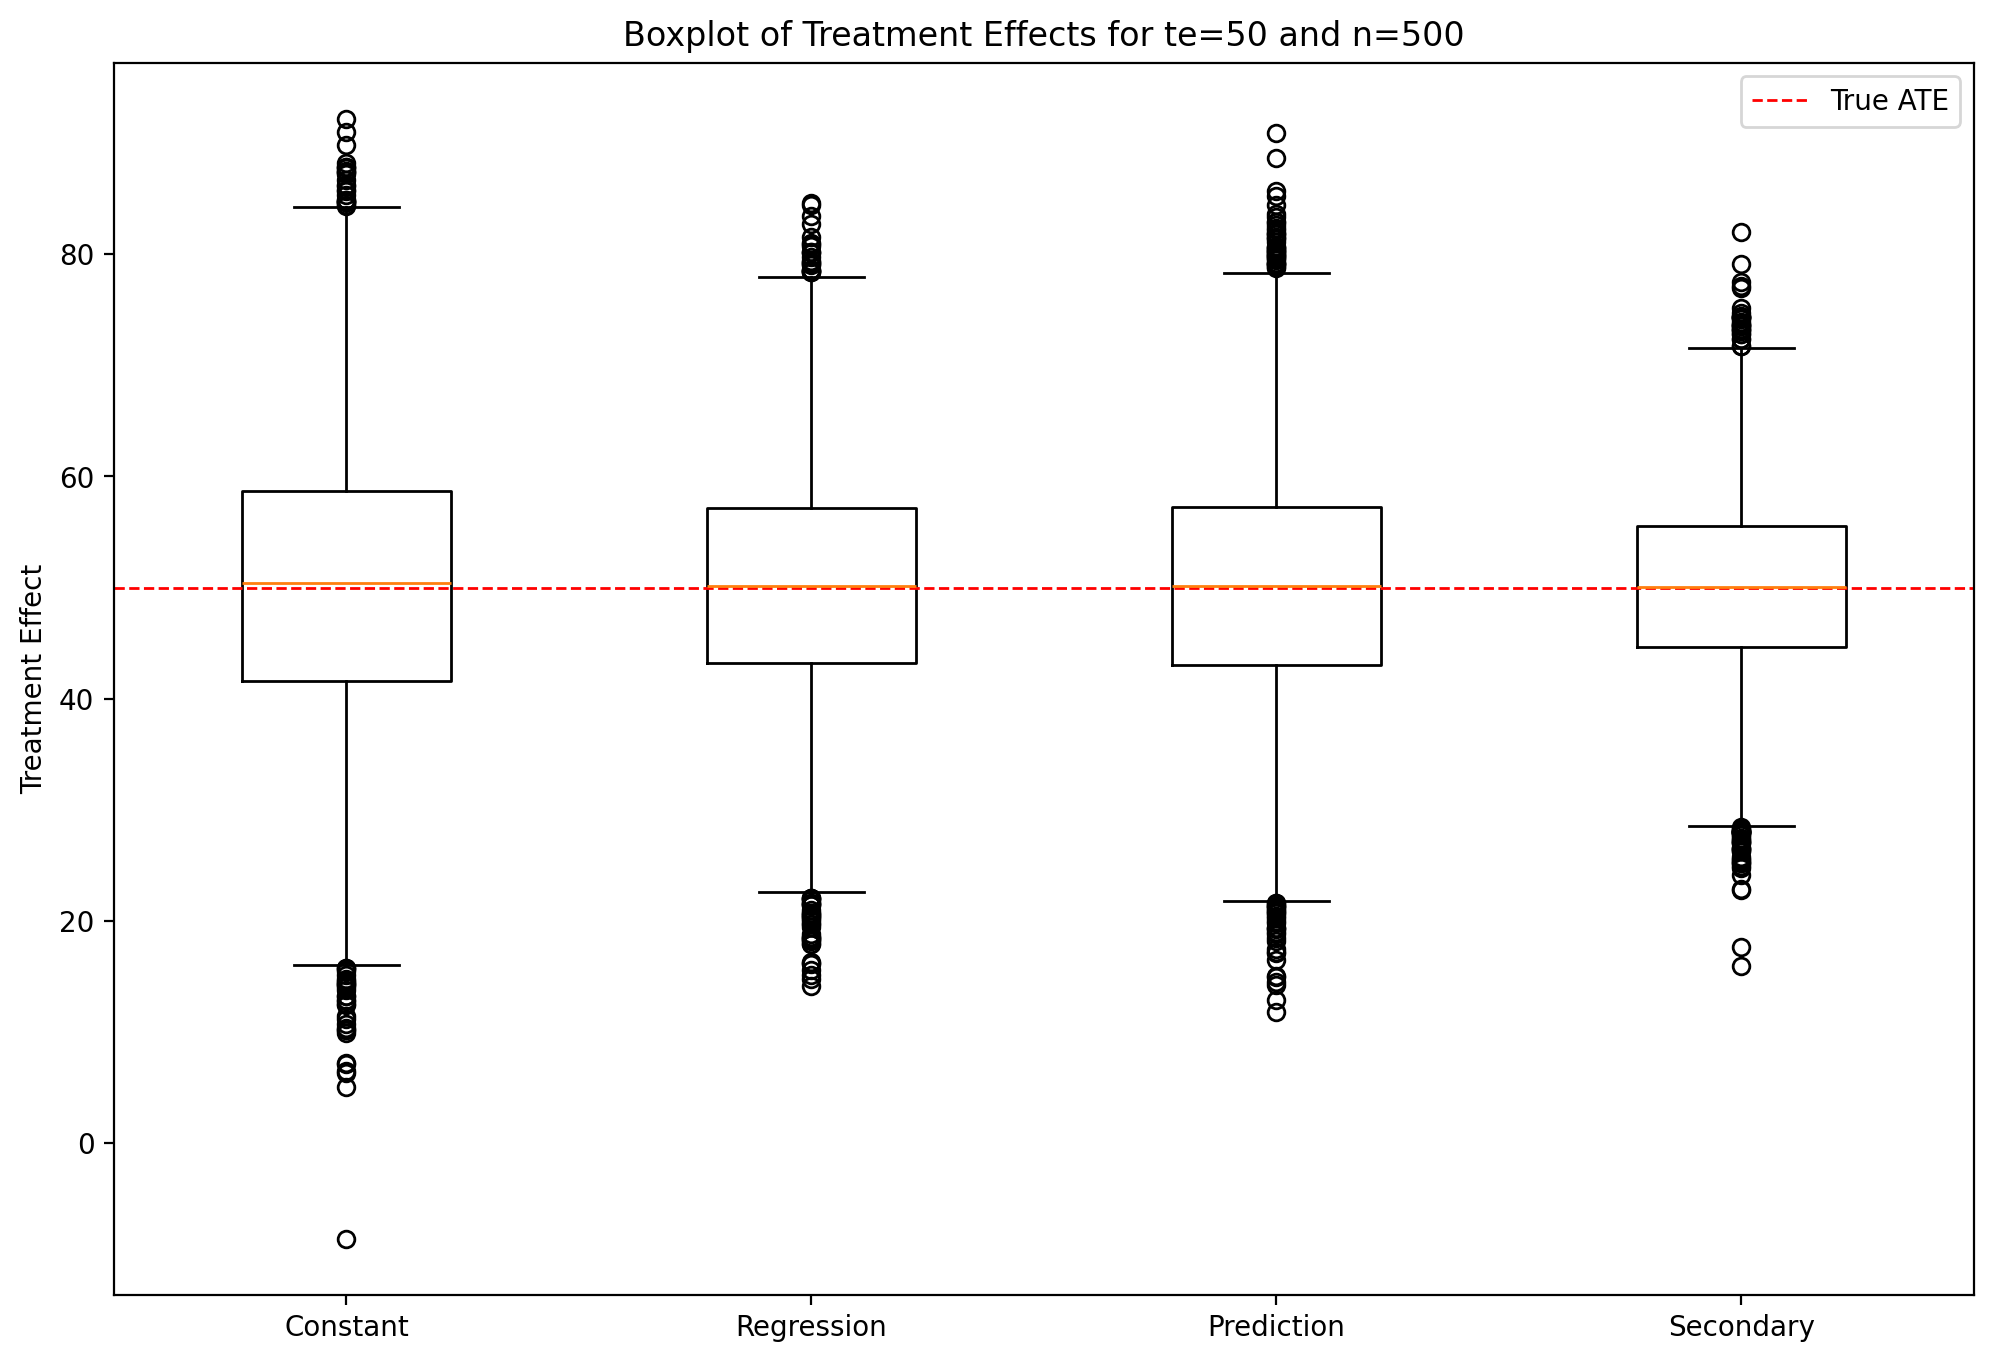

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_62147/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


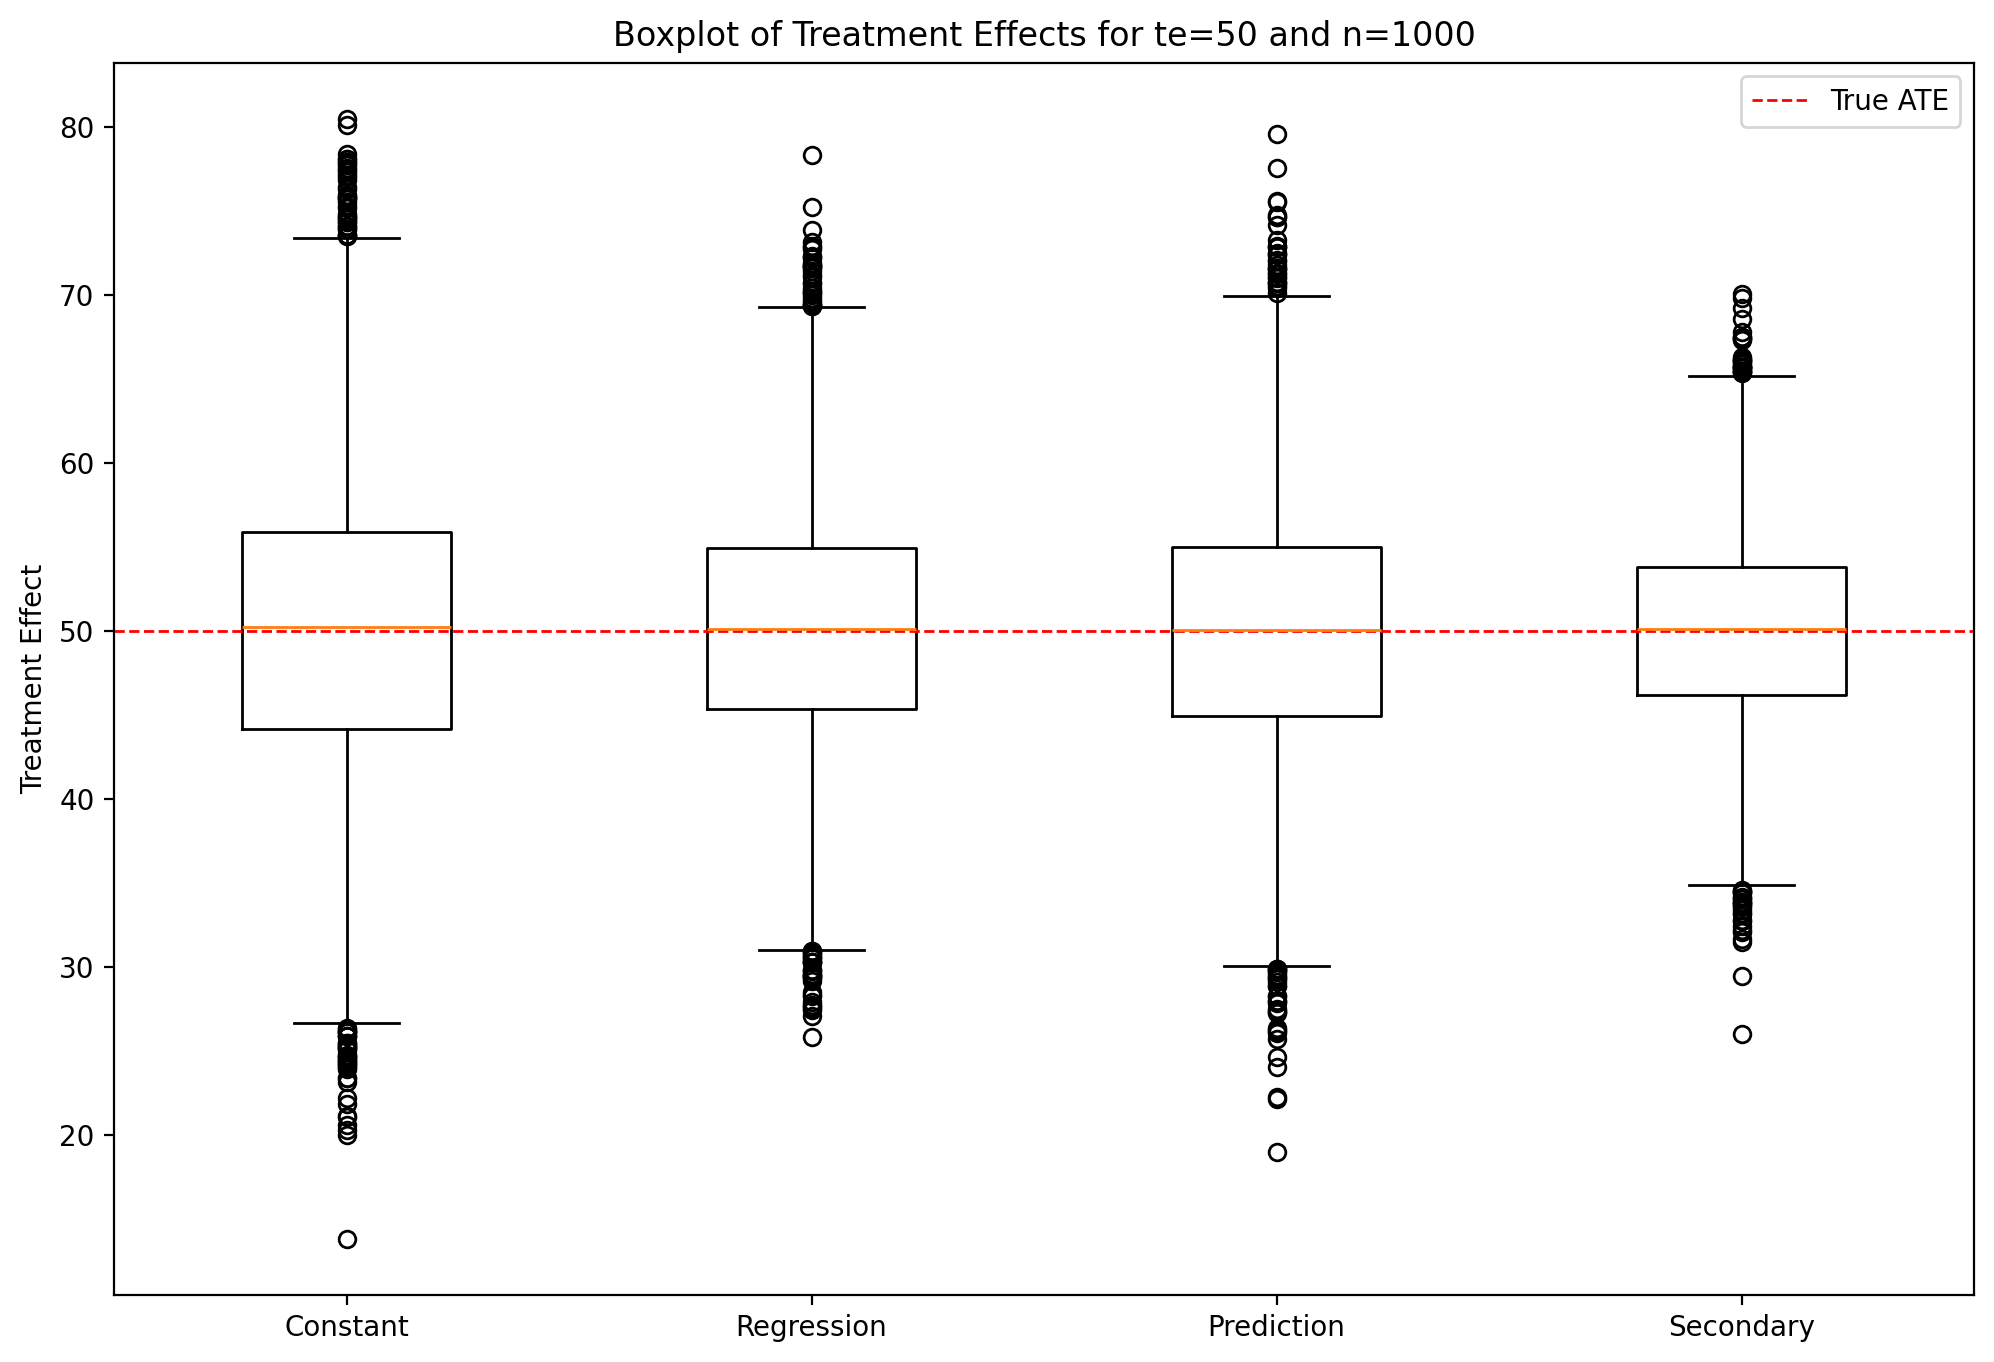

In [13]:
# Create boxplots for each combination of te and n
for te in te_lst:
    for n in n_lst:
        # Filter the results for the current combination of te and n
        subset = results.iloc[(idx - total):(idx - total + r)]
        
        # Create a new figure
        plt.figure(figsize=(12, 8), dpi=dpi)
        
        # Create boxplots for each method
        plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],
                    labels=['Constant', 'Regression', 'Prediction', 'Secondary'])
        
        # Add a horizontal line for the true treatment effect
        plt.axhline(y=te, color='r', linestyle='--', linewidth=1, label='True ATE')
        
        # Add title and labels
        plt.title(f'Boxplot of Treatment Effects for te={te} and n={n}')
        plt.ylabel('Treatment Effect')
        plt.legend()
        
        # Show the plot
        plt.show()
        # Update the index for the next subset
        idx += r

In [11]:
# summarize the results dataframe
# first average the treatment effect estimate for each n and te and method combination
summary = results.groupby(['te', 'n']).mean().reset_index()
# also add a column for standard deviation of treatment effect estimates for each n and te and method combination
summary['Constant SD'] = results.groupby(['te', 'n'])['Constant ATE'].std().values
summary['Regression SD'] = results.groupby(['te', 'n'])['Regression ATE'].std().values
summary['Prediction SD'] = results.groupby(['te', 'n'])['Prediction ATE'].std().values
summary['Secondary SD'] = results.groupby(['te', 'n'])['Secondary ATE'].std().values
# add columns denoting bias of each method 
# if te is 0, set bias to be the absolute difference between the estimate and 0
# otherwise, set bias to be the relative difference between the estimate and te
summary['Constant Bias'] = np.where(summary['te'] == 0, np.abs(summary['Constant ATE']), np.abs((summary['Constant ATE'] - summary['te'])/summary['te']))
summary['Regression Bias'] = np.where(summary['te'] == 0, np.abs(summary['Regression ATE']), np.abs((summary['Regression ATE'] - summary['te'])/summary['te']))
summary['Prediction Bias'] = np.where(summary['te'] == 0, np.abs(summary['Prediction ATE']), np.abs((summary['Prediction ATE'] - summary['te'])/summary['te']))
summary['Secondary Bias'] = np.where(summary['te'] == 0, np.abs(summary['Secondary ATE']), np.abs((summary['Secondary ATE'] - summary['te'])/summary['te']))

# add columns denoting % variance reduction relative to the constant model. Set variance equal to SE^2, and variance reduction equal to 1 - (variance/constant variance)
summary['Regression Var Reduction'] = 1 - (summary['Regression SE']**2)/(summary['Constant SE']**2)
summary['Prediction Var Reduction'] = 1 - (summary['Prediction SE']**2)/(summary['Constant SE']**2)
summary['Secondary Var Reduction'] = 1 - (summary['Secondary SE']**2)/(summary['Constant SE']**2)
print(summary)

    te     n  Constant ATE  Constant SE  Constant Rej  Regression ATE  \
0    0   100      0.069939    27.965089        0.0557        0.009509   
1    0   200      0.175997    19.788198        0.0527       -0.008773   
2    0   500     -0.037030    12.518398        0.0486       -0.009106   
3    0  1000     -0.076373     8.853021        0.0489       -0.086665   
4   10   100     10.052113    27.965728        0.0642       10.108679   
5   10   200     10.209705    19.771322        0.0809       10.177294   
6   10   500      9.993902    12.519258        0.1223        9.958038   
7   10  1000      9.965136     8.852742        0.2034        9.934869   
8   20   100     19.963489    27.962919        0.1117       20.217935   
9   20   200     20.117369    19.783931        0.1784       20.022401   
10  20   500     20.022422    12.517555        0.3599       19.962298   
11  20  1000     20.039546     8.852248        0.6147       20.104110   
12  50   100     50.793393    27.981522        0.44

In [17]:

latex_table = r"""
\begin{table*}
\caption{Results for the Highway Incidents (HI) dataset. Bias is given as the relative bias to the true treatment effect $\tau$, except when $\tau = 0$ where the average treatment effect estimate is given instead. Variance reduction is measured relative to the constant model. Rejection proportion is the proportion of the 10,000 simulations in which $H_0$ was rejected at significance level $\alpha = 5\%$.}
\centering
\begin{tabular}[t]{llrrrrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{3}{c}{Variance Reduction} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-9} \cmidrule(l{3pt}r{3pt}){10-13}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{13}{l}{}\\
100&0 & {100_0_tau_c} & {100_0_tau_r} & {100_0_tau_p} & {100_0_tau_s} & {100_0_var_r} & {100_0_var_p} & {100_0_var_s} & {100_0_rej_c} & {100_0_rej_r} & {100_0_rej_p} & {100_0_rej_s}\\
&10 & {100_10_tau_c} & {100_10_tau_r} & {100_10_tau_p} & {100_10_tau_s} & {100_10_var_r} & {100_10_var_p} & {100_10_var_s} & {100_10_rej_c} & {100_10_rej_r} & {100_10_rej_p} & {100_10_rej_s}\\
&20 & {100_20_tau_c} & {100_20_tau_r} & {100_20_tau_p} & {100_20_tau_s} & {100_20_var_r} & {100_20_var_p} & {100_20_var_s} & {100_20_rej_c} & {100_20_rej_r} & {100_20_rej_p} & {100_20_rej_s}\\
&50 & {100_50_tau_c} & {100_50_tau_r} & {100_50_tau_p} & {100_50_tau_s} & {100_50_var_r} & {100_50_var_p} & {100_50_var_s} & {100_50_rej_c} & {100_50_rej_r} & {100_50_rej_p} & {100_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{13}{l}{}\\
200&0 & {200_0_tau_c} & {200_0_tau_r} & {200_0_tau_p} & {200_0_tau_s} & {200_0_var_r} & {200_0_var_p} & {200_0_var_s} & {200_0_rej_c} & {200_0_rej_r} & {200_0_rej_p} & {200_0_rej_s}\\
&10 & {200_10_tau_c} & {200_10_tau_r} & {200_10_tau_p} & {200_10_tau_s} & {200_10_var_r} & {200_10_var_p} & {200_10_var_s} & {200_10_rej_c} & {200_10_rej_r} & {200_10_rej_p} & {200_10_rej_s}\\
&20 & {200_20_tau_c} & {200_20_tau_r} & {200_20_tau_p} & {200_20_tau_s} & {200_20_var_r} & {200_20_var_p} & {200_20_var_s} & {200_20_rej_c} & {200_20_rej_r} & {200_20_rej_p} & {200_20_rej_s}\\
&50 & {200_50_tau_c} & {200_50_tau_r} & {200_50_tau_p} & {200_50_tau_s} & {200_50_var_r} & {200_50_var_p} & {200_50_var_s} & {200_50_rej_c} & {200_50_rej_r} & {200_50_rej_p} & {200_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{13}{l}{}\\
500&0 & {500_0_tau_c} & {500_0_tau_r} & {500_0_tau_p} & {500_0_tau_s} & {500_0_var_r} & {500_0_var_p} & {500_0_var_s} & {500_0_rej_c} & {500_0_rej_r} & {500_0_rej_p} & {500_0_rej_s}\\
&10 & {500_10_tau_c} & {500_10_tau_r} & {500_10_tau_p} & {500_10_tau_s} & {500_10_var_r} & {500_10_var_p} & {500_10_var_s} & {500_10_rej_c} & {500_10_rej_r} & {500_10_rej_p} & {500_10_rej_s}\\
&20 & {500_20_tau_c} & {500_20_tau_r} & {500_20_tau_p} & {500_20_tau_s} & {500_20_var_r} & {500_20_var_p} & {500_20_var_s} & {500_20_rej_c} & {500_20_rej_r} & {500_20_rej_p} & {500_20_rej_s}\\
&50 & {500_50_tau_c} & {500_50_tau_r} & {500_50_tau_p} & {500_50_tau_s} & {500_50_var_r} & {500_50_var_p} & {500_50_var_s} & {500_50_rej_c} & {500_50_rej_r} & {500_50_rej_p} & {500_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{13}{l}{}\\
1000&0 & {1000_0_tau_c} & {1000_0_tau_r} & {1000_0_tau_p} & {1000_0_tau_s} & {1000_0_var_r} & {1000_0_var_p} & {1000_0_var_s} & {1000_0_rej_c} & {1000_0_rej_r} & {1000_0_rej_p} & {1000_0_rej_s}\\
&10 & {1000_10_tau_c} & {1000_10_tau_r} & {1000_10_tau_p} & {1000_10_tau_s} & {1000_10_var_r} & {1000_10_var_p} & {1000_10_var_s} & {1000_10_rej_c} & {1000_10_rej_r} & {1000_10_rej_p} & {1000_10_rej_s}\\
&20 & {1000_20_tau_c} & {1000_20_tau_r} & {1000_20_tau_p} & {1000_20_tau_s} & {1000_20_var_r} & {1000_20_var_p} & {1000_20_var_s} & {1000_20_rej_c} & {1000_20_rej_r} & {1000_20_rej_p} & {1000_20_rej_s}\\
&50 & {1000_50_tau_c} & {1000_50_tau_r} & {1000_50_tau_p} & {1000_50_tau_s} & {1000_50_var_r} & {1000_50_var_p} & {1000_50_var_s} & {1000_50_rej_c} & {1000_50_rej_r} & {1000_50_rej_p} & {1000_50_rej_s}\\
\bottomrule
\end{tabular}
\label{tab: HI summary}
\end{table*}
"""



for te in te_lst:
    factor = 1 if te == 0 else 100
    for n in n_lst:
        subset = summary[(summary['te'] == te) & (summary['n'] == n)]
        bias_constant = subset['Constant Bias'].values[0] * factor
        bias_regression = subset['Regression Bias'].values[0] * factor
        bias_prediction = subset['Prediction Bias'].values[0] * factor
        bias_secondary = subset['Secondary Bias'].values[0] * factor
        var_reduction_regression = subset['Regression Var Reduction'].values[0] * 100
        var_reduction_prediction = subset['Prediction Var Reduction'].values[0] * 100
        var_reduction_secondary = subset['Secondary Var Reduction'].values[0] * 100
        rej_constant = subset['Constant Rej'].values[0] * 100
        rej_regression = subset['Regression Rej'].values[0] * 100
        rej_prediction = subset['Prediction Rej'].values[0] * 100
        rej_secondary = subset['Secondary Rej'].values[0] * 100
        
        if te == 0:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}")
        else:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}\%")
        
        latex_table = latex_table.replace(f"{n}_{te}_var_r", f"{var_reduction_regression:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_var_p", f"{var_reduction_prediction:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_var_s", f"{var_reduction_secondary:.2f}\%")
        
        latex_table = latex_table.replace(f"{n}_{te}_rej_c", f"{rej_constant:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_r", f"{rej_regression:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_p", f"{rej_prediction:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_s", f"{rej_secondary:.2f}\%")
  
print(latex_table)


\begin{table*}
\caption{Results for the Highway Incidents (HI) dataset. Bias is given as the relative bias to the true treatment effect $\tau$, except when $\tau = 0$ where the average treatment effect estimate is given instead. Variance reduction is measured relative to the constant model. Rejection proportion is the proportion of the 10,000 simulations in which $H_0$ was rejected at significance level $\alpha = 5\%$.}
\centering
\begin{tabular}[t]{llrrrrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{3}{c}{Variance Reduction} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-9} \cmidrule(l{3pt}r{3pt}){10-13}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{13}{l}{}\\
100&0 & {0.07} & {0.01} & {0.07} & {0.13} & {36.16\%} & {3

In [16]:

latex_table = r"""
\begin{table*}
\caption{Results for the Highway Incidents (HI) dataset. Bias is given as the relative bias to the true treatment effect $\tau$, except when $\tau = 0$ where the average treatment effect estimate is given instead. Rejection proportion is the proportion of the 10,000 simulations in which $H_0$ was rejected at significance level $\alpha = 5\%$.}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
100&0 & {100_0_tau_c} & {100_0_tau_r} & {100_0_tau_p} & {100_0_tau_s} & {100_0_rej_c} & {100_0_rej_r} & {100_0_rej_p} & {100_0_rej_s}\\
&10 & {100_10_tau_c} & {100_10_tau_r} & {100_10_tau_p} & {100_10_tau_s} & {100_10_rej_c} & {100_10_rej_r} & {100_10_rej_p} & {100_10_rej_s}\\
&20 & {100_20_tau_c} & {100_20_tau_r} & {100_20_tau_p} & {100_20_tau_s} & {100_20_rej_c} & {100_20_rej_r} & {100_20_rej_p} & {100_20_rej_s}\\
&50 & {100_50_tau_c} & {100_50_tau_r} & {100_50_tau_p} & {100_50_tau_s} & {100_50_rej_c} & {100_50_rej_r} & {100_50_rej_p} & {100_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
200&0 & {200_0_tau_c} & {200_0_tau_r} & {200_0_tau_p} & {200_0_tau_s} & {200_0_rej_c} & {200_0_rej_r} & {200_0_rej_p} & {200_0_rej_s}\\
&10 & {200_10_tau_c} & {200_10_tau_r} & {200_10_tau_p} & {200_10_tau_s} & {200_10_rej_c} & {200_10_rej_r} & {200_10_rej_p} & {200_10_rej_s}\\
&20 & {200_20_tau_c} & {200_20_tau_r} & {200_20_tau_p} & {200_20_tau_s} & {200_20_rej_c} & {200_20_rej_r} & {200_20_rej_p} & {200_20_rej_s}\\
&50 & {200_50_tau_c} & {200_50_tau_r} & {200_50_tau_p} & {200_50_tau_s} & {200_50_rej_c} & {200_50_rej_r} & {200_50_rej_p} & {200_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
500&0 & {500_0_tau_c} & {500_0_tau_r} & {500_0_tau_p} & {500_0_tau_s} & {500_0_rej_c} & {500_0_rej_r} & {500_0_rej_p} & {500_0_rej_s}\\
&10 & {500_10_tau_c} & {500_10_tau_r} & {500_10_tau_p} & {500_10_tau_s} & {500_10_rej_c} & {500_10_rej_r} & {500_10_rej_p} & {500_10_rej_s}\\
&20 & {500_20_tau_c} & {500_20_tau_r} & {500_20_tau_p} & {500_20_tau_s} & {500_20_rej_c} & {500_20_rej_r} & {500_20_rej_p} & {500_20_rej_s}\\
&50 & {500_50_tau_c} & {500_50_tau_r} & {500_50_tau_p} & {500_50_tau_s} & {500_50_rej_c} & {500_50_rej_r} & {500_50_rej_p} & {500_50_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
1000&0 & {1000_0_tau_c} & {1000_0_tau_r} & {1000_0_tau_p} & {1000_0_tau_s} & {1000_0_rej_c} & {1000_0_rej_r} & {1000_0_rej_p} & {1000_0_rej_s}\\
&10 & {1000_10_tau_c} & {1000_10_tau_r} & {1000_10_tau_p} & {1000_10_tau_s} & {1000_10_rej_c} & {1000_10_rej_r} & {1000_10_rej_p} & {1000_10_rej_s}\\
&20 & {1000_20_tau_c} & {1000_20_tau_r} & {1000_20_tau_p} & {1000_20_tau_s} & {1000_20_rej_c} & {1000_20_rej_r} & {1000_20_rej_p} & {1000_20_rej_s}\\
&50 & {1000_50_tau_c} & {1000_50_tau_r} & {1000_50_tau_p} & {1000_50_tau_s} & {1000_50_rej_c} & {1000_50_rej_r} & {1000_50_rej_p} & {1000_50_rej_s}\\
\bottomrule
\end{tabular}
\label{tab: HI summary}
\end{table*}
"""


for te in te_lst:
    factor = 1 if te == 0 else 100
    for n in n_lst:
        subset = summary[(summary['te'] == te) & (summary['n'] == n)]
        bias_constant = subset['Constant Bias'].values[0] * factor
        bias_regression = subset['Regression Bias'].values[0] * factor
        bias_prediction = subset['Prediction Bias'].values[0] * factor
        bias_secondary = subset['Secondary Bias'].values[0] * factor
        rej_constant = subset['Constant Rej'].values[0] * 100
        rej_regression = subset['Regression Rej'].values[0] * 100
        rej_prediction = subset['Prediction Rej'].values[0] * 100
        rej_secondary = subset['Secondary Rej'].values[0] * 100
        
        if te == 0:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}")
        else:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_c", f"{rej_constant:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_r", f"{rej_regression:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_p", f"{rej_prediction:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_s", f"{rej_secondary:.2f}\%")
        
  
print(latex_table)





\begin{table*}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}100&0 & {0.07} & {0.01} & {0.07} & {0.13} & {5.57\%} & {5.38\%} & {5.01\%} & {5.33\%}\\
\hspace{1em}&10 & {0.52\%} & {1.09\%} & {0.08\%} & {0.70\%} & {6.42\%} & {7.35\%} & {7.29\%} & {8.72\%}\\
\hspace{1em}&20 & {0.18\%} & {1.09\%} & {0.83\%} & {0.33\%} & {11.17\%} & {14.84\%} & {13.95\%} & {21.07\%}\\
\hspace{1em}&50 & {1.59\%} & {0.83\%} & {0.80\%} & {0.04\%} & {44.20\%} & {61.63\%} & {57.48\%} & {80.90\%}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}200&0 & {0.18} & {0.01} & {0.24} & {0.07} & {5.27\%} & {5.23\%} & {5.15\%} & {5.15\%}\\
\hs